# Homework 5: Adversarial Attacks and Defenses

Duke University

ECE661 Fall 2022

## Setup

You shouldn't have to change anything in these cells

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

# Custom
import models
import attacks

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [2]:
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size = 64, shuffle=True, )
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.ToTensor()),
    batch_size = 64, shuffle=False, )

In [3]:
def test_model(mdl, loader, device):
    mdl.eval()
    running_correct = 0.
    running_loss = 0.
    running_total = 0.
    with torch.no_grad():
        for batch_idx,(data,labels) in enumerate(loader):
            data = data.to(device); labels = labels.to(device)
            clean_outputs = mdl(data)
            clean_loss = F.cross_entropy(clean_outputs, labels)
            _,clean_preds = clean_outputs.max(1)
            running_correct += clean_preds.eq(labels).sum().item()
            running_loss += clean_loss.item()
            running_total += labels.size(0)
    clean_acc = running_correct/running_total
    clean_loss = running_loss/len(loader)
    mdl.train()
    return clean_acc,clean_loss

## Model training

Train a model and save the checkpoint. This cell is used in Lab-1 and Lab-3

Model A:

In [5]:
## Pick a model architecture
net = models.NetA().to(device)
#net = models.NetB().to(device)

## Checkpoint name for this model
model_checkpoint = "netA_standard.pt"
#model_checkpoint = "netB_standard.pt"

## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

## Training Loop
for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)
        
        # Forward pass
        outputs = net(data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)
        
    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model    
    torch.save(net.state_dict(), model_checkpoint)
    
    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.84340; TrainLoss: 0.43227; TestAcc: 0.88270; TestLoss: 0.32506
Epoch: [ 1 / 20 ]; TrainAcc: 0.90212; TrainLoss: 0.26985; TestAcc: 0.89300; TestLoss: 0.29338
Epoch: [ 2 / 20 ]; TrainAcc: 0.91578; TrainLoss: 0.22997; TestAcc: 0.90740; TestLoss: 0.26212
Epoch: [ 3 / 20 ]; TrainAcc: 0.92530; TrainLoss: 0.20241; TestAcc: 0.91510; TestLoss: 0.24423
Epoch: [ 4 / 20 ]; TrainAcc: 0.93427; TrainLoss: 0.17848; TestAcc: 0.91450; TestLoss: 0.24866
Epoch: [ 5 / 20 ]; TrainAcc: 0.94143; TrainLoss: 0.15829; TestAcc: 0.91690; TestLoss: 0.24310
Epoch: [ 6 / 20 ]; TrainAcc: 0.94780; TrainLoss: 0.14046; TestAcc: 0.91210; TestLoss: 0.27118
Epoch: [ 7 / 20 ]; TrainAcc: 0.95455; TrainLoss: 0.12395; TestAcc: 0.91610; TestLoss: 0.26627
Epoch: [ 8 / 20 ]; TrainAcc: 0.96067; TrainLoss: 0.10738; TestAcc: 0.91870; TestLoss: 0.27145
Epoch: [ 9 / 20 ]; TrainAcc: 0.96488; TrainLoss: 0.09490; TestAcc: 0.91140; TestLoss: 0.29415
Epoch: [ 10 / 20 ]; TrainAcc: 0.96955; TrainLoss: 0.08320; T

In [6]:
# print the architecture of the model A
print(net)

NetA(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=10, bias=True)
  )
)


Model B:

In [8]:
## Pick a model architecture
# net = models.NetA().to(device)
net = models.NetB().to(device)

## Checkpoint name for this model
# model_checkpoint = "netA_standard.pt"
model_checkpoint = "netB_standard.pt"

## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

## Training Loop
for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)
        
        # Forward pass
        outputs = net(data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)
        
    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model    
    torch.save(net.state_dict(), model_checkpoint)
    
    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.84705; TrainLoss: 0.42082; TestAcc: 0.88610; TestLoss: 0.31961
Epoch: [ 1 / 20 ]; TrainAcc: 0.90602; TrainLoss: 0.26136; TestAcc: 0.90060; TestLoss: 0.27543
Epoch: [ 2 / 20 ]; TrainAcc: 0.92058; TrainLoss: 0.21979; TestAcc: 0.91450; TestLoss: 0.23706
Epoch: [ 3 / 20 ]; TrainAcc: 0.92892; TrainLoss: 0.19188; TestAcc: 0.91600; TestLoss: 0.23123
Epoch: [ 4 / 20 ]; TrainAcc: 0.93690; TrainLoss: 0.17234; TestAcc: 0.91860; TestLoss: 0.23035
Epoch: [ 5 / 20 ]; TrainAcc: 0.94358; TrainLoss: 0.15457; TestAcc: 0.91790; TestLoss: 0.23955
Epoch: [ 6 / 20 ]; TrainAcc: 0.94800; TrainLoss: 0.14098; TestAcc: 0.91860; TestLoss: 0.23962
Epoch: [ 7 / 20 ]; TrainAcc: 0.95393; TrainLoss: 0.12509; TestAcc: 0.91710; TestLoss: 0.24414
Epoch: [ 8 / 20 ]; TrainAcc: 0.95925; TrainLoss: 0.11099; TestAcc: 0.92020; TestLoss: 0.23472
Epoch: [ 9 / 20 ]; TrainAcc: 0.96368; TrainLoss: 0.09953; TestAcc: 0.91530; TestLoss: 0.26900
Epoch: [ 10 / 20 ]; TrainAcc: 0.96785; TrainLoss: 0.08737; T

In [9]:
# print the architecture of the model B
print(net)

NetB(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3136, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=10, bias=True)
  )
)


**Visualize some perturbed samples**

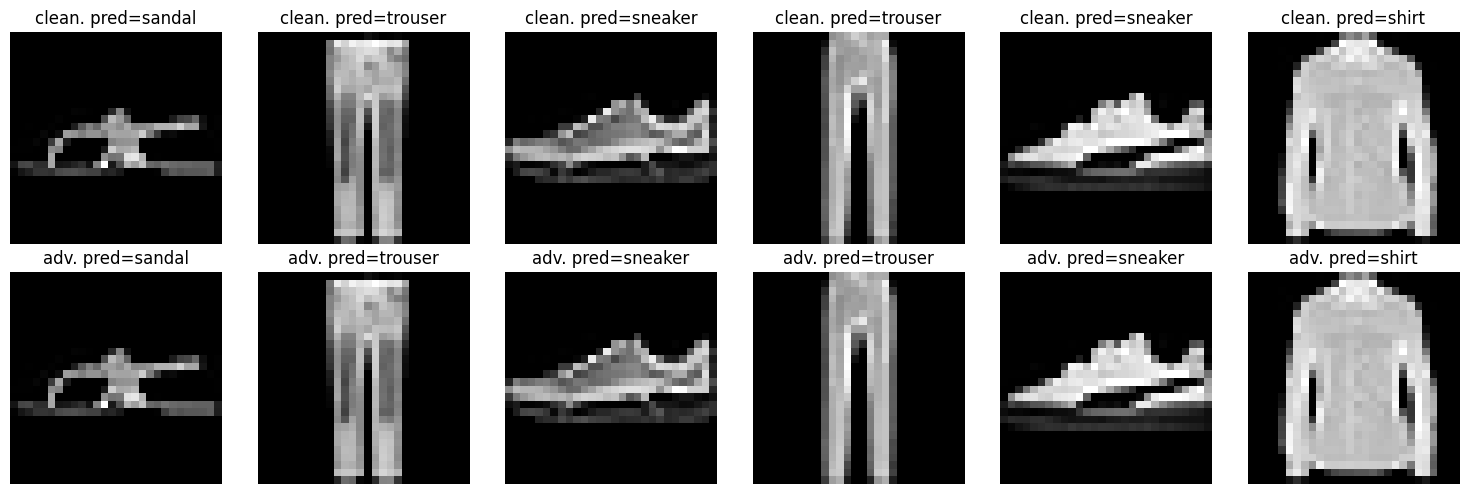

In [4]:
classes = ["t-shirt", "trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","boot"]
net = models.NetA().to(device)
net.load_state_dict(torch.load("netA_standard.pt"))
for data,labels in test_loader:
        data = data.to(device); labels = labels.to(device)

        ###
        # Compute and apply adversarial perturbation to data
        EPS= 0
        ITS=10
        ALP = 1.85*(EPS/ITS)

        adv_data = attacks.PGD_attack(model=net, dat=data, lbl=labels, eps=EPS, alpha=ALP, iters=ITS, device=device, rand_start=True)

        ###
        
        # Compute preds
        with torch.no_grad():
            clean_outputs = net(data)
            _,clean_preds = clean_outputs.max(1)
            clean_preds = clean_preds.cpu().squeeze().numpy()
            adv_outputs = net(adv_data)
            _,adv_preds = adv_outputs.max(1)
            adv_preds = adv_preds.cpu().squeeze().numpy()

        # Plot some samples
        inds = random.sample(list(range(data.size(0))),6)
        plt.figure(figsize=(15,5))
        for jj in range(6):
            plt.subplot(2,6,jj+1);plt.imshow(data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
            plt.title("clean. pred={}".format(classes[clean_preds[inds[jj]]]))
        for jj in range(6):
            plt.subplot(2,6,6+jj+1);plt.imshow(adv_data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
            plt.title("adv. pred={}".format(classes[adv_preds[inds[jj]]]))
        plt.tight_layout()
        plt.show()
        break

In [19]:
def attack_viz(eps, attack_type):
    classes = ["t-shirt", "trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","boot"]
    net = models.NetA().to(device)
    net.load_state_dict(torch.load("netA_standard.pt"))
    for data,labels in test_loader:
            data = data.to(device); labels = labels.to(device)

            ###
            # Compute and apply adversarial perturbation to data
            EPS= eps
            ITS=10
            ALP = 1.85*(EPS/ITS)

            if attack_type == "PGD":
                adv_data = attacks.PGD_attack(model=net, dat=data, lbl=labels, eps=EPS, alpha=ALP, iters=ITS, device=device, rand_start=True)
            elif attack_type == "FGSM":
                 adv_data = attacks.FGSM_attack(model=net, dat=data, lbl=labels, eps=EPS, device=device)
            elif attack_type == "rFGSM":
                 adv_data = attacks.rFGSM_attack(model=net, dat=data, lbl=labels, eps=EPS, device=device)
            elif attack_type == "FGM_L2":
                 adv_data = attacks.FGM_L2_attack(model=net, dat=data, lbl=labels, eps=EPS, device=device) 
            ###
            
            # Compute preds
            with torch.no_grad():
                clean_outputs = net(data)
                _,clean_preds = clean_outputs.max(1)
                clean_preds = clean_preds.cpu().squeeze().numpy()
                adv_outputs = net(adv_data)
                _,adv_preds = adv_outputs.max(1)
                adv_preds = adv_preds.cpu().squeeze().numpy()

            # Plot some samples
            inds = random.sample(list(range(data.size(0))),6)
            plt.figure(figsize=(15,5))
            for jj in range(6):
                plt.subplot(2,6,jj+1);plt.imshow(data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
                plt.title("clean. pred={}".format(classes[clean_preds[inds[jj]]]))
            for jj in range(6):
                plt.subplot(2,6,6+jj+1);plt.imshow(adv_data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
                plt.title("adv. pred={}".format(classes[adv_preds[inds[jj]]]))
            plt.tight_layout()
            plt.show()
            break

PGD attack -- eps: 0.0


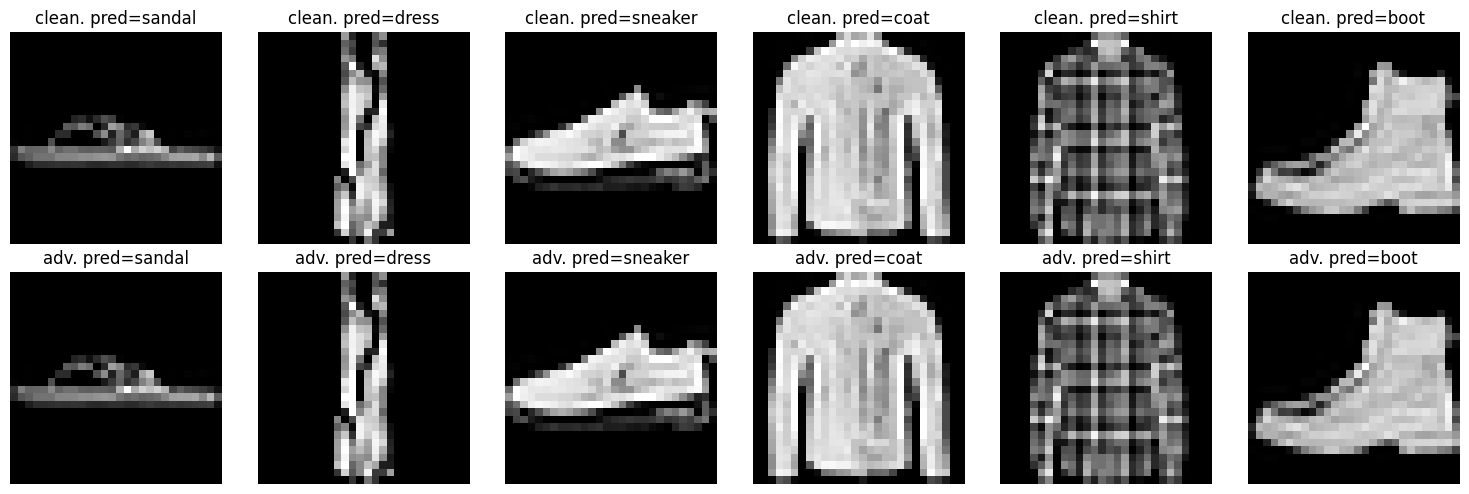

PGD attack -- eps: 0.02


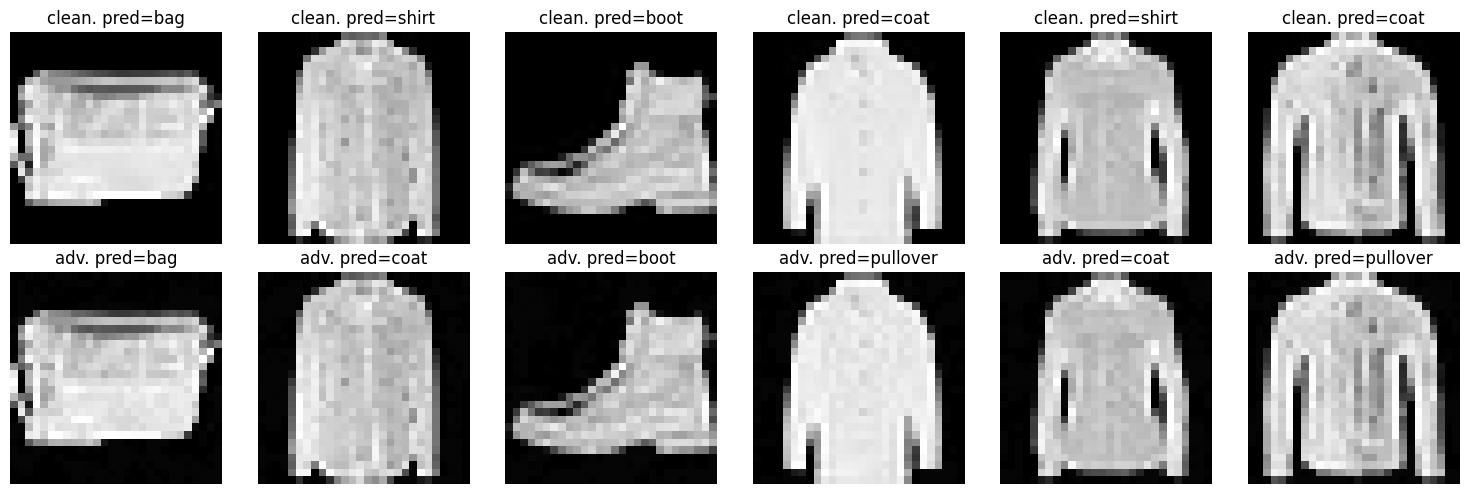

PGD attack -- eps: 0.04


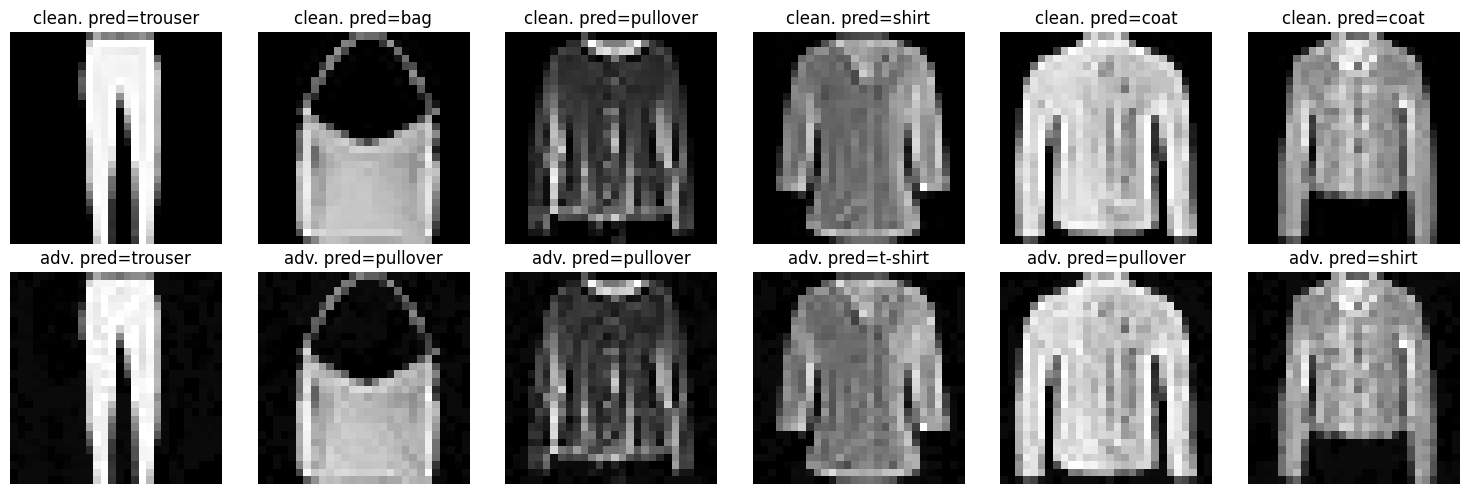

PGD attack -- eps: 0.06


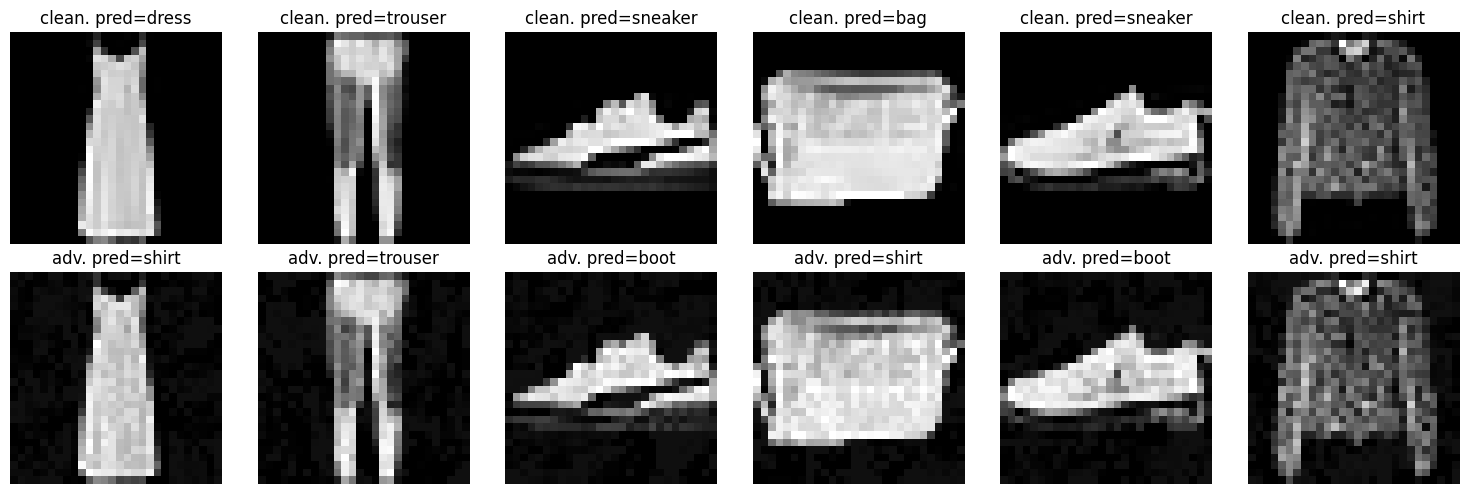

PGD attack -- eps: 0.08


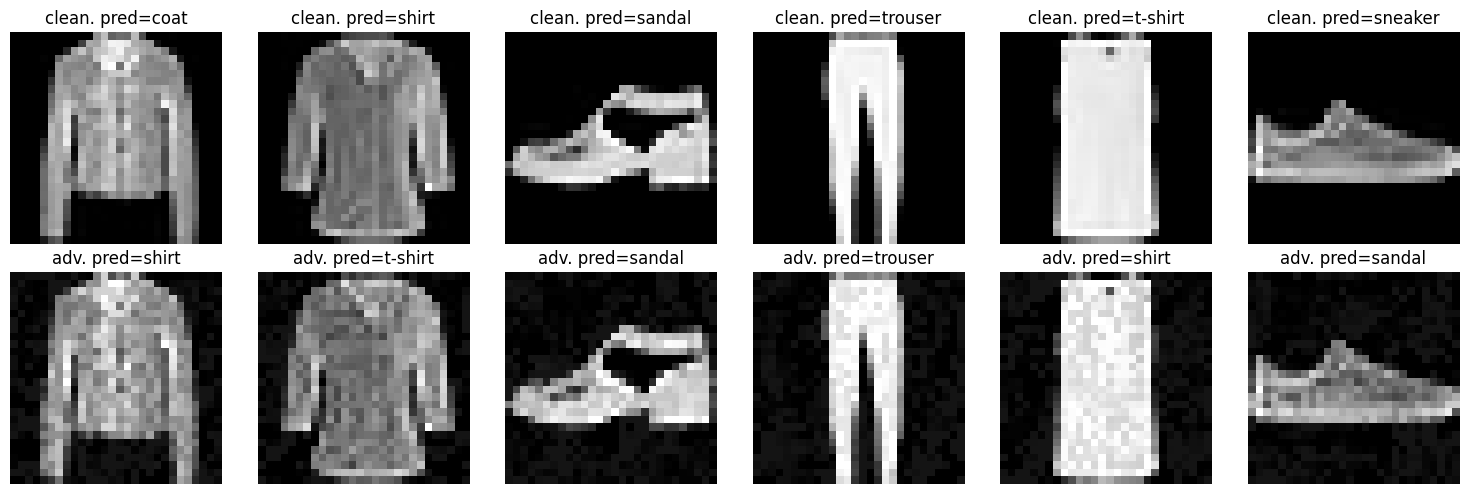

PGD attack -- eps: 0.1


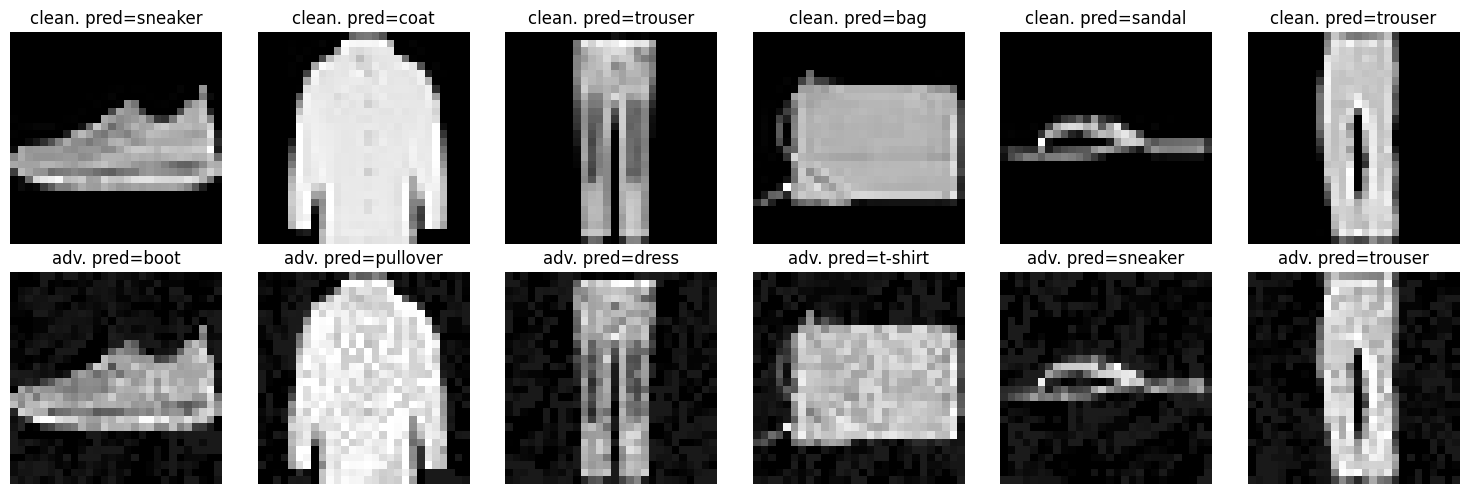

PGD attack -- eps: 0.12


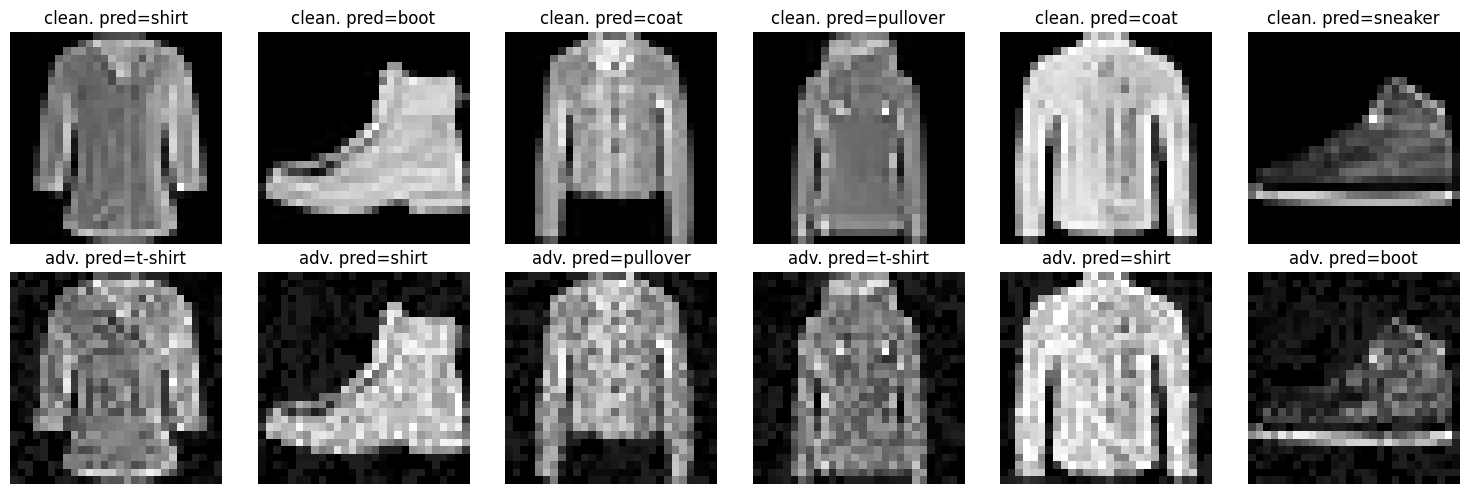

PGD attack -- eps: 0.14


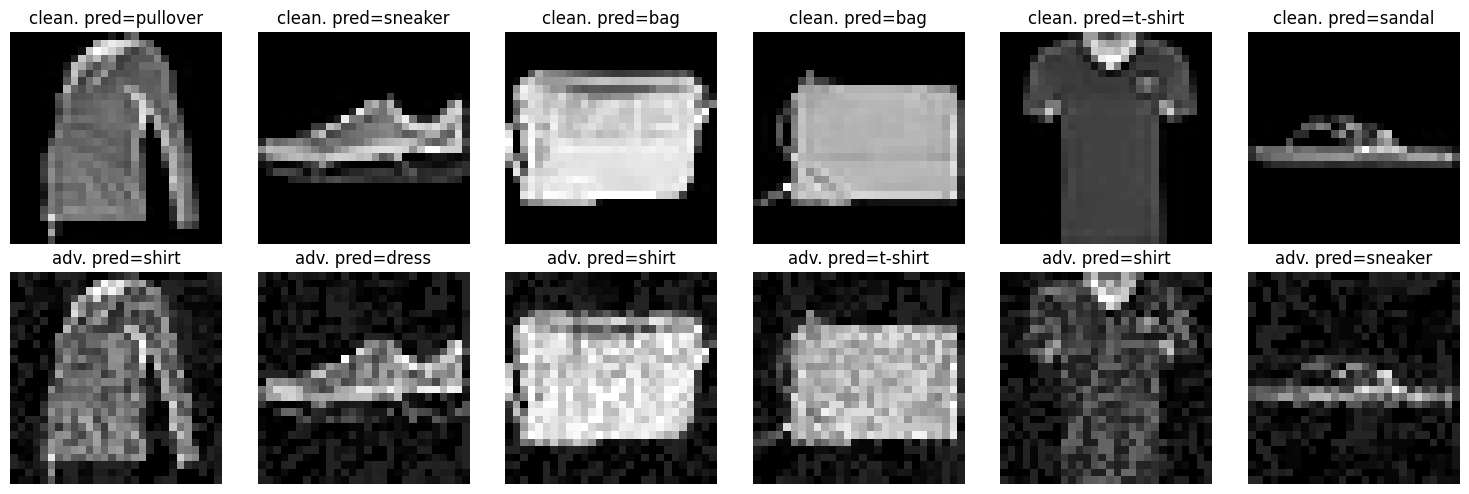

PGD attack -- eps: 0.16


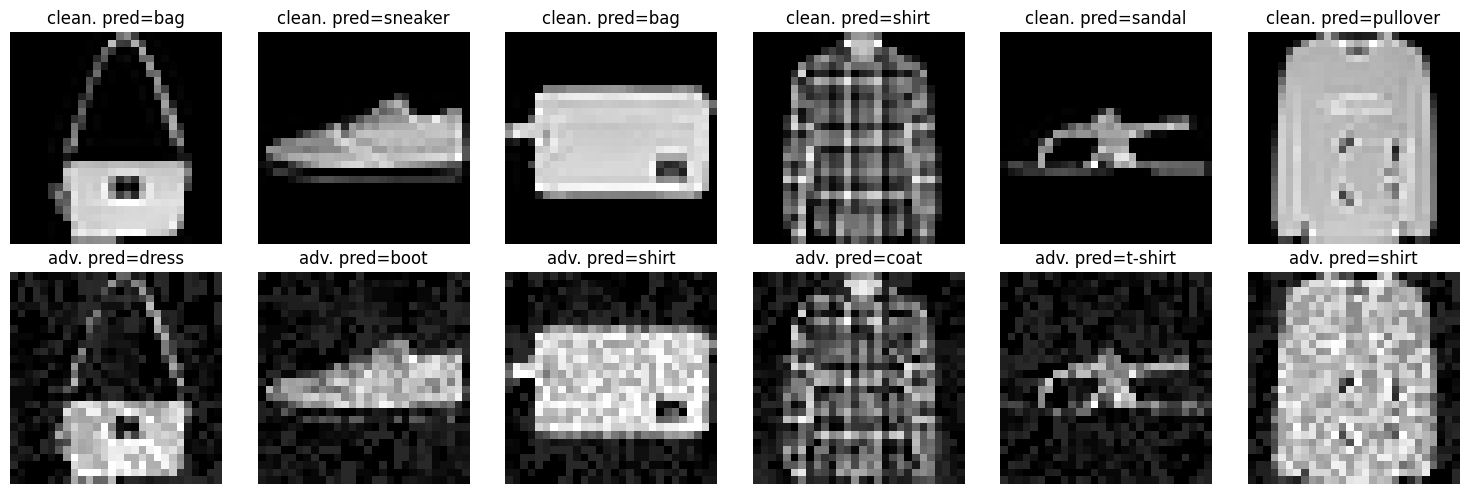

PGD attack -- eps: 0.18


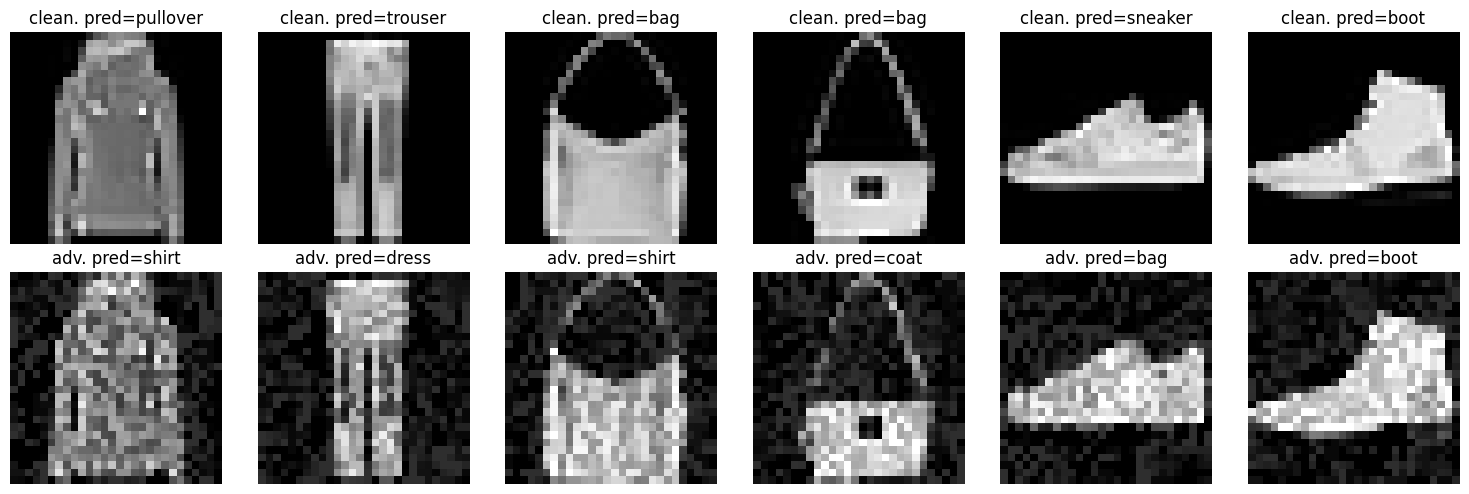

PGD attack -- eps: 0.2


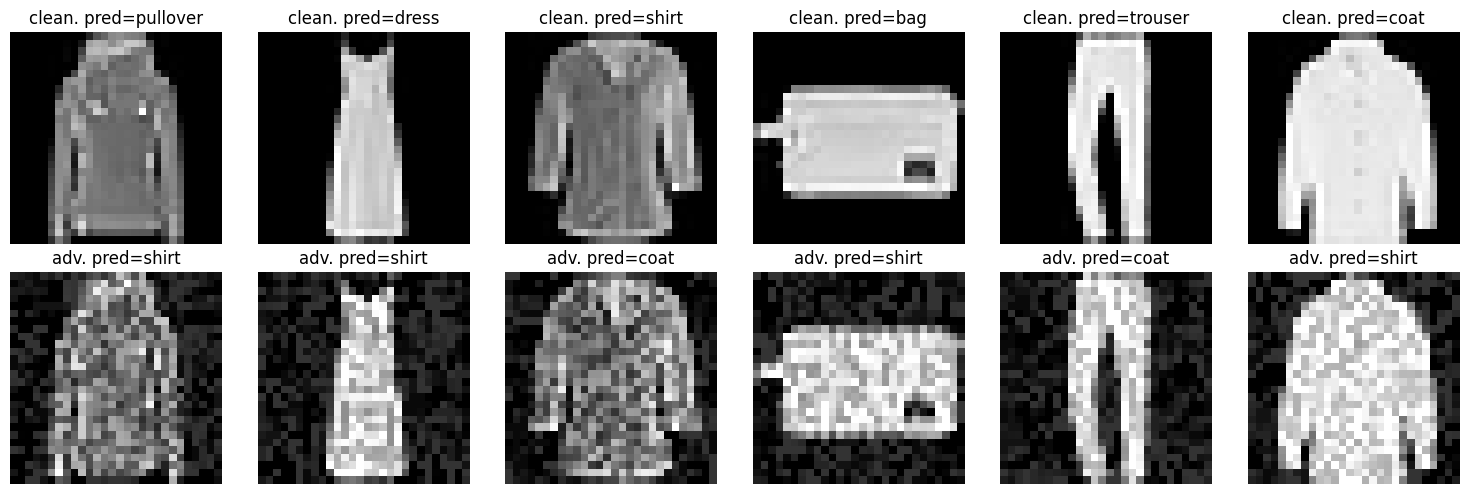

In [5]:
for eps in np.linspace(0,0.2,11):
    print("PGD attack -- eps:", eps)
    attack_viz(eps, "PGD")

FGSM attack -- eps: 0.0


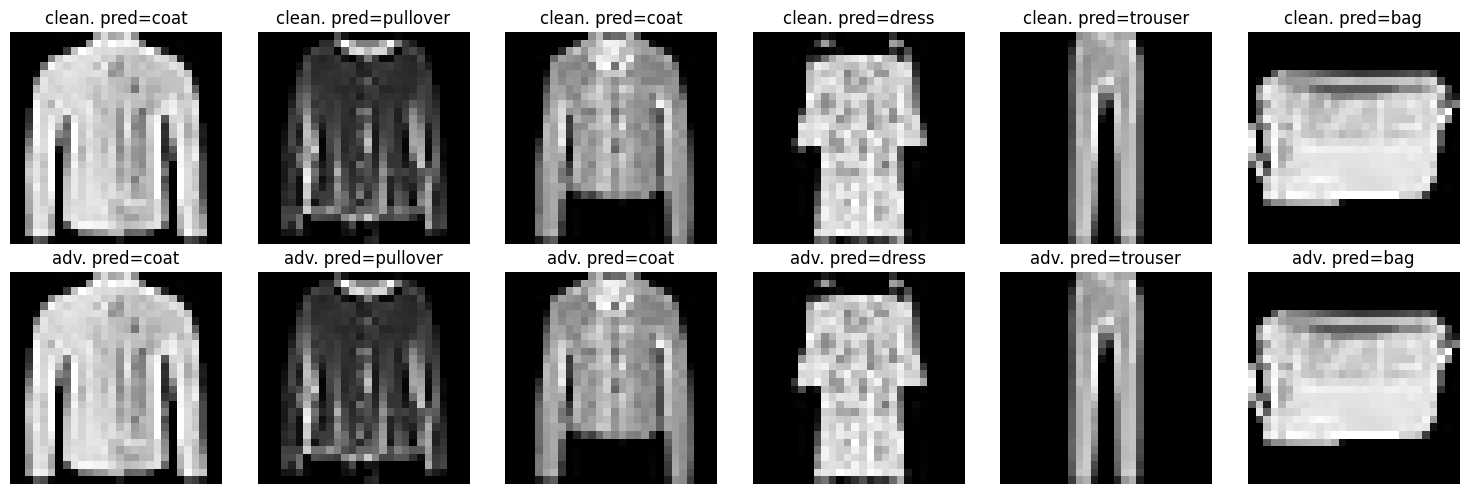

FGSM attack -- eps: 0.02


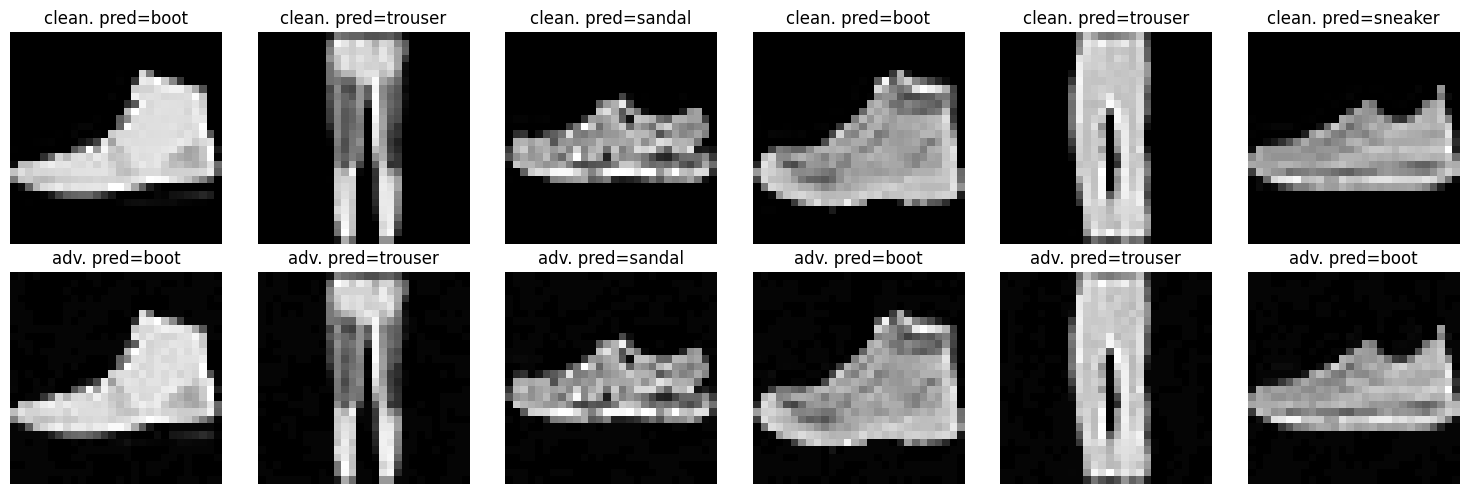

FGSM attack -- eps: 0.04


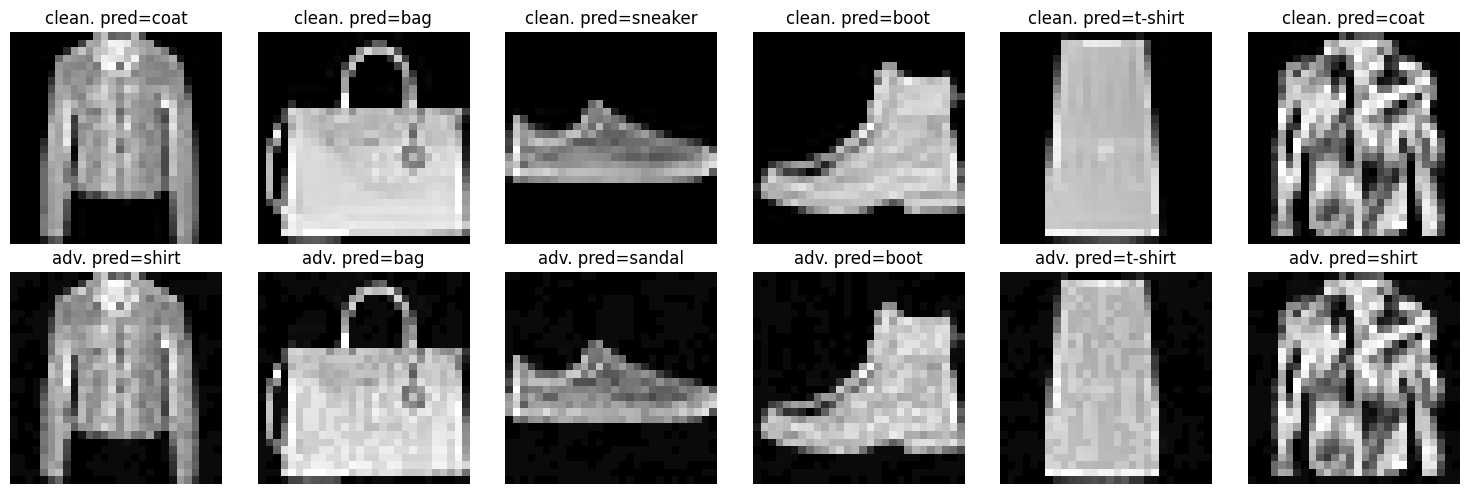

FGSM attack -- eps: 0.06


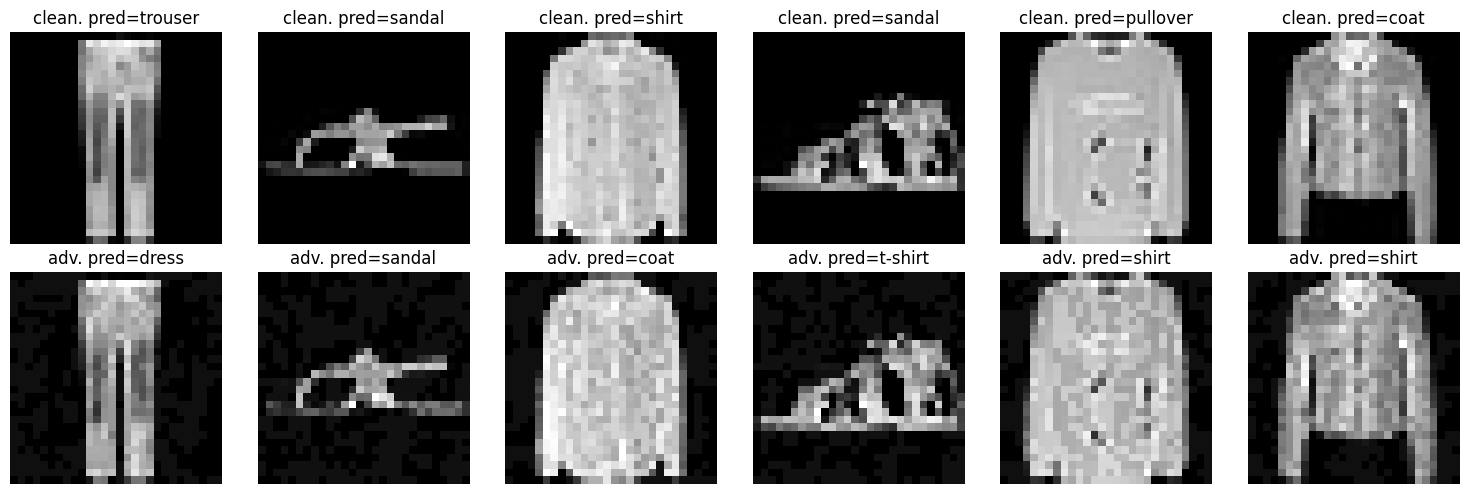

FGSM attack -- eps: 0.08


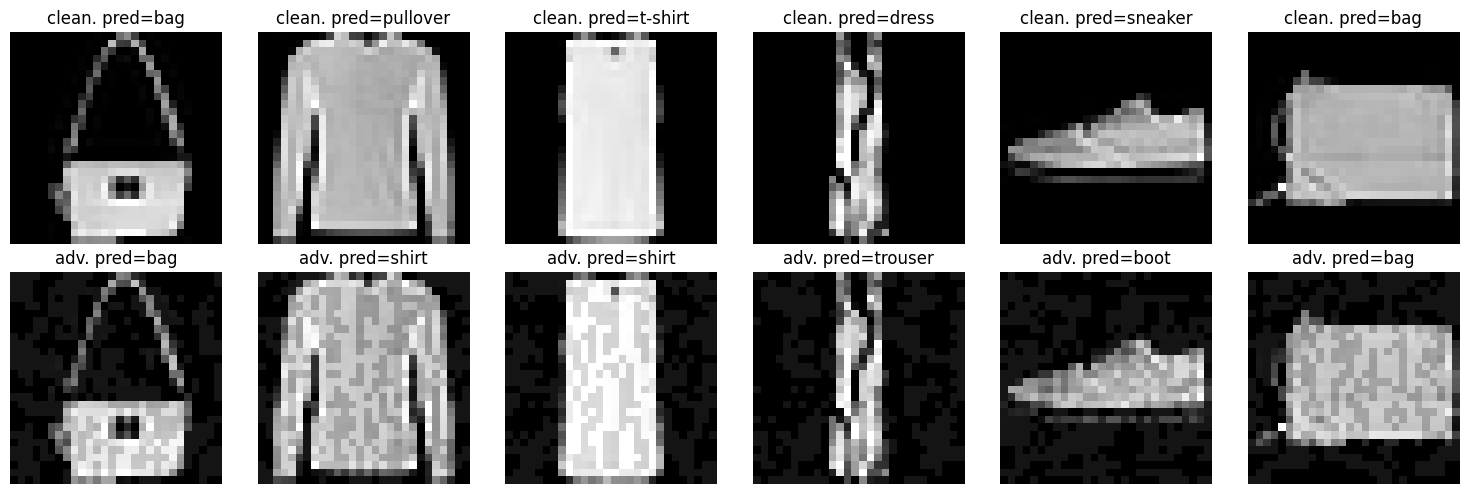

FGSM attack -- eps: 0.1


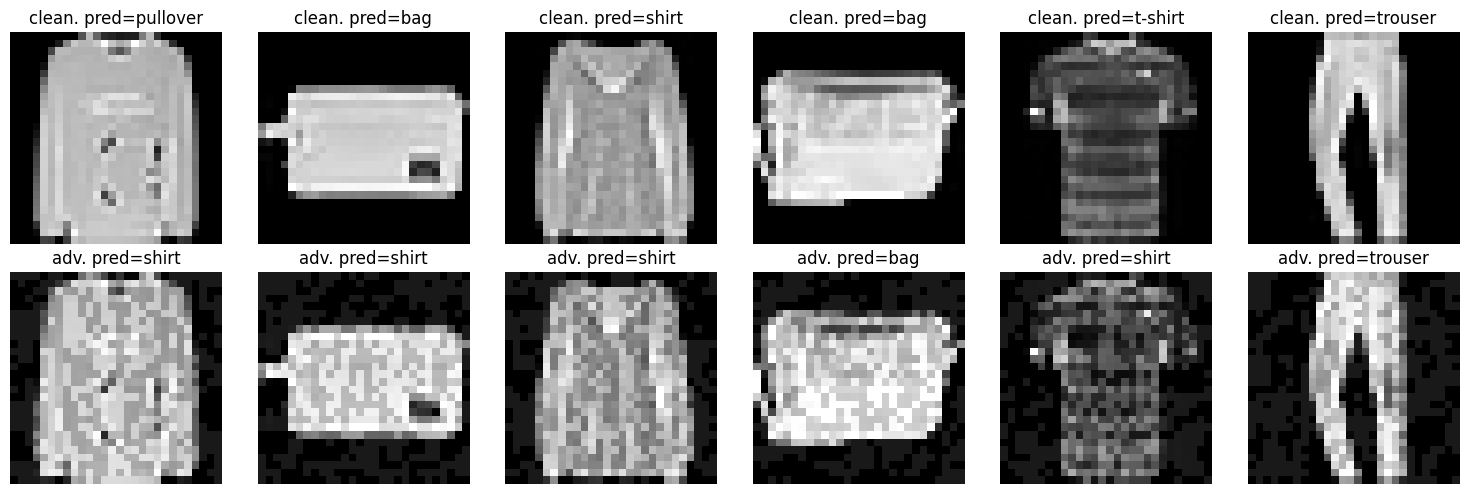

FGSM attack -- eps: 0.12


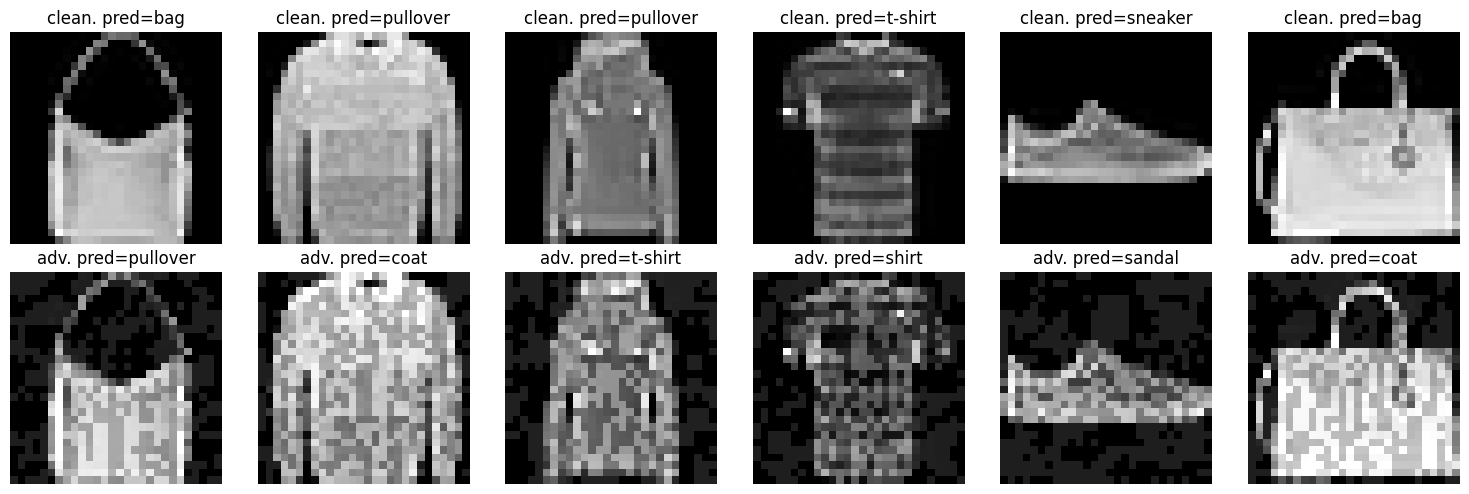

FGSM attack -- eps: 0.14


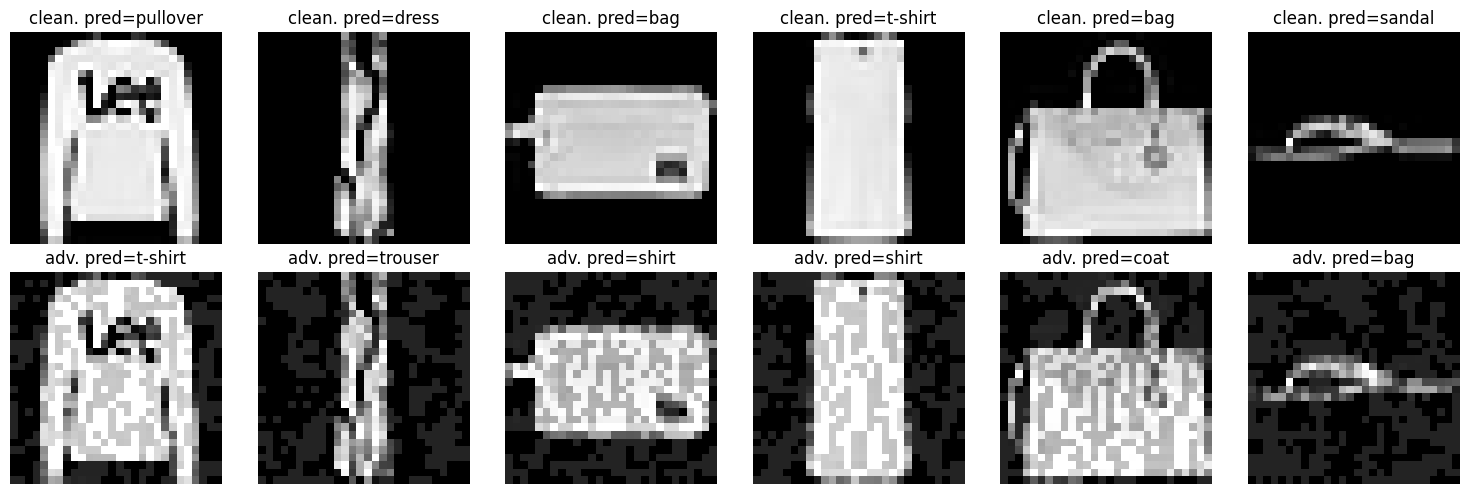

FGSM attack -- eps: 0.16


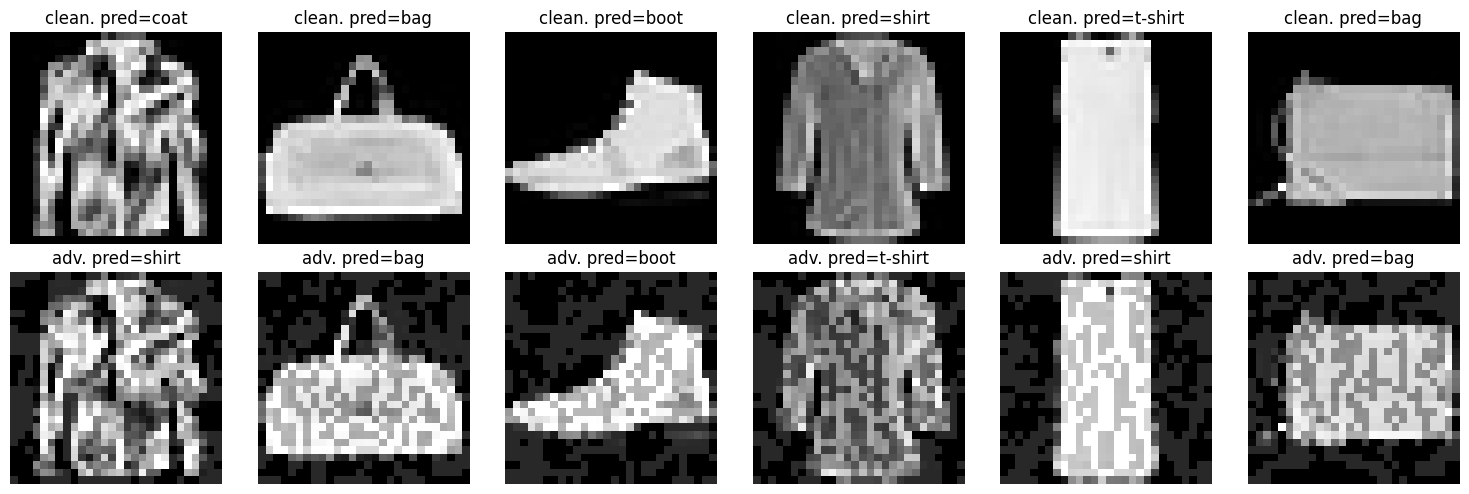

FGSM attack -- eps: 0.18


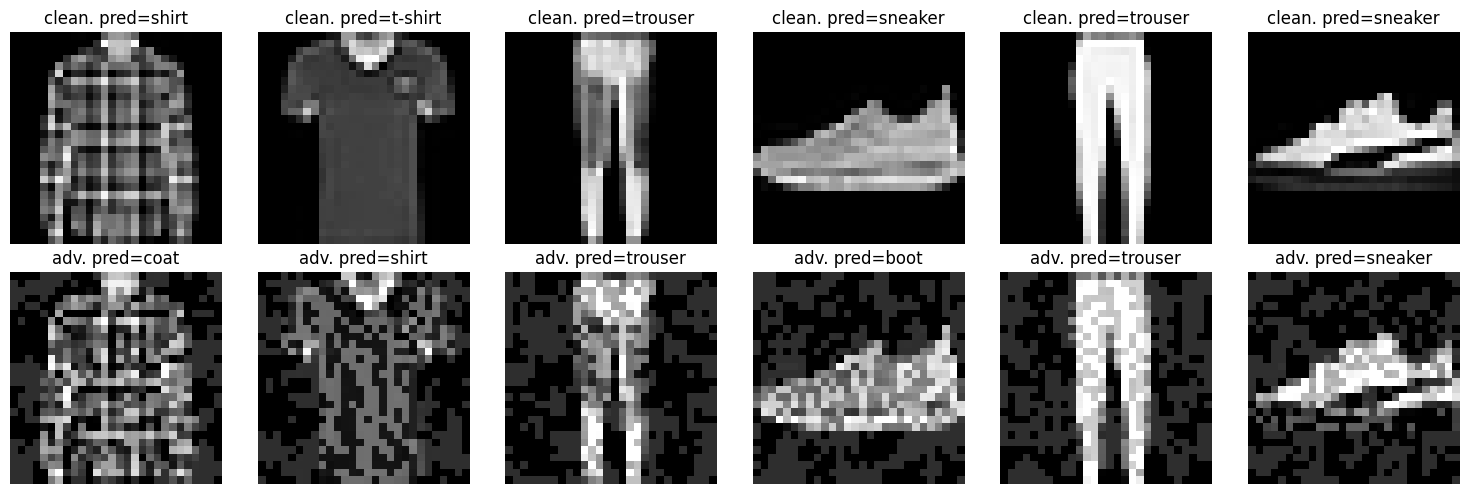

FGSM attack -- eps: 0.2


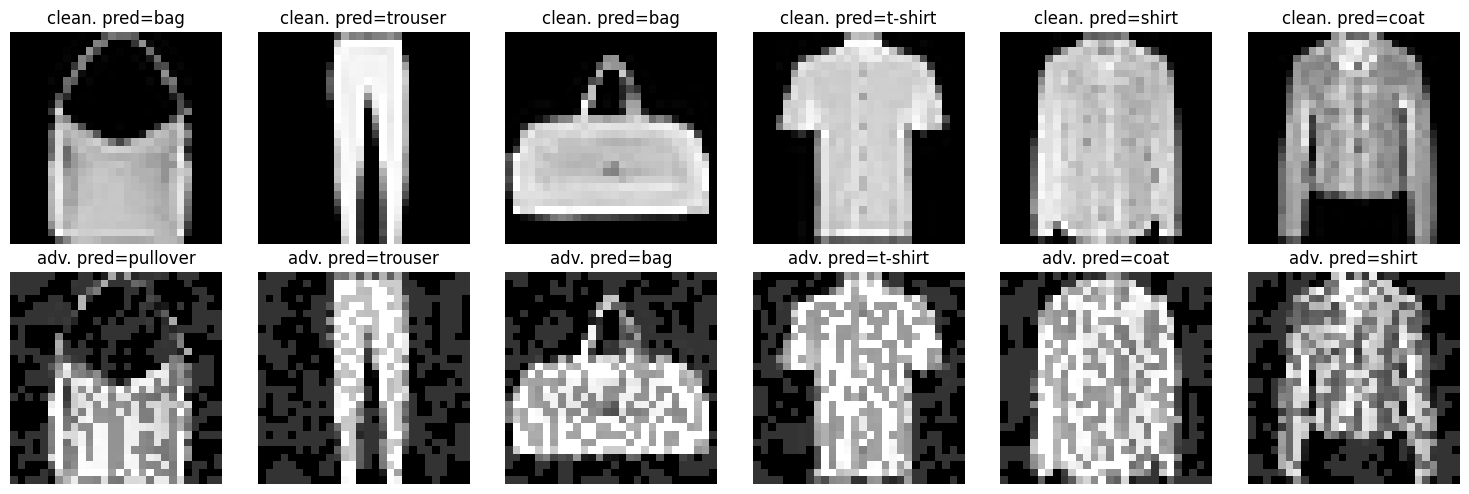

In [6]:
for eps in np.linspace(0,0.2,11):
    print("FGSM attack -- eps:", eps)
    attack_viz(eps, "FGSM")

rFGM attack -- eps: 0.0


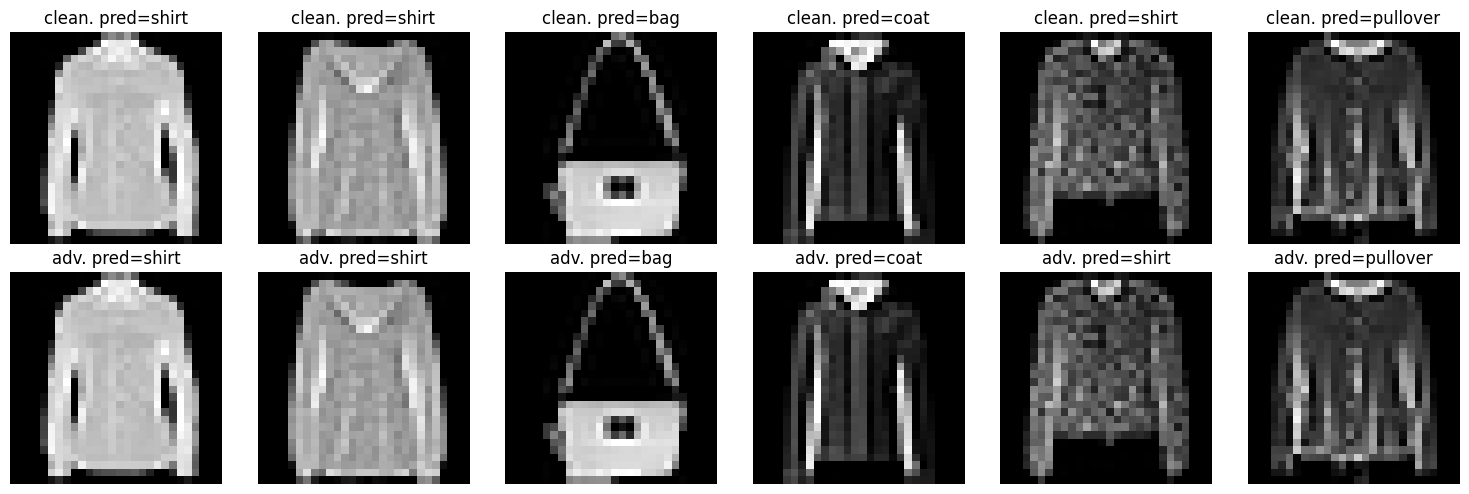

rFGM attack -- eps: 0.02


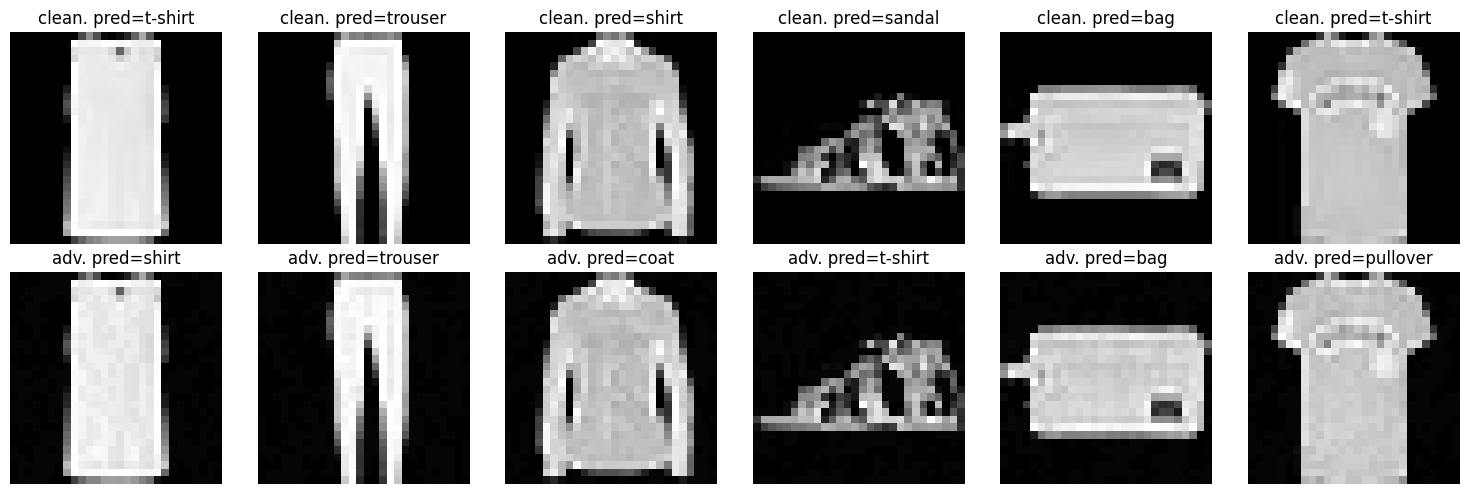

rFGM attack -- eps: 0.04


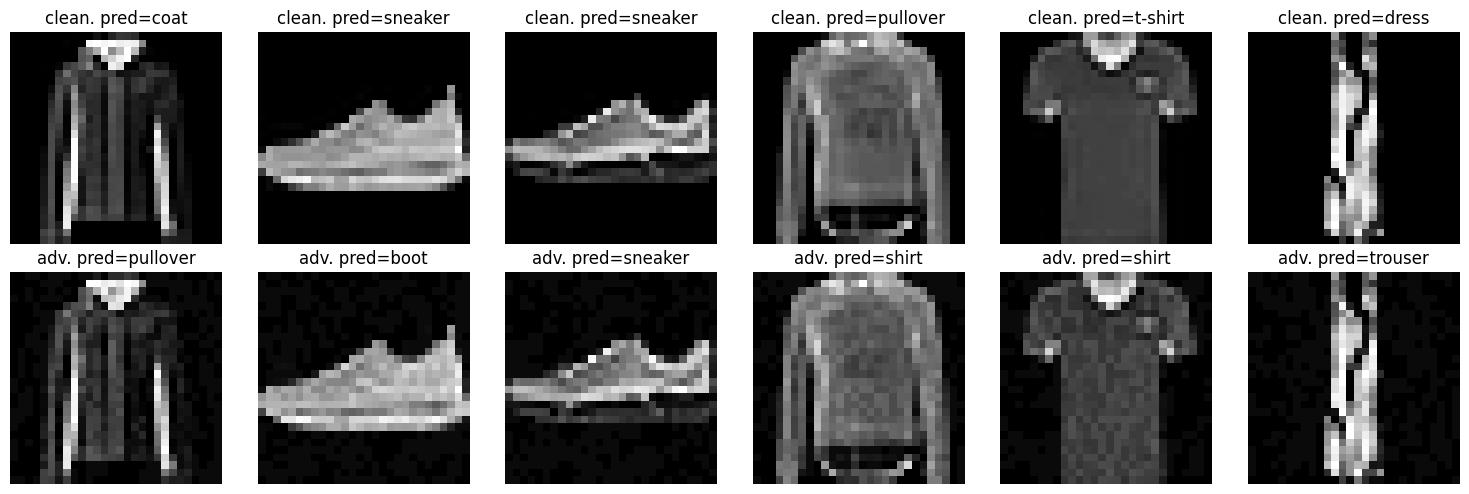

rFGM attack -- eps: 0.06


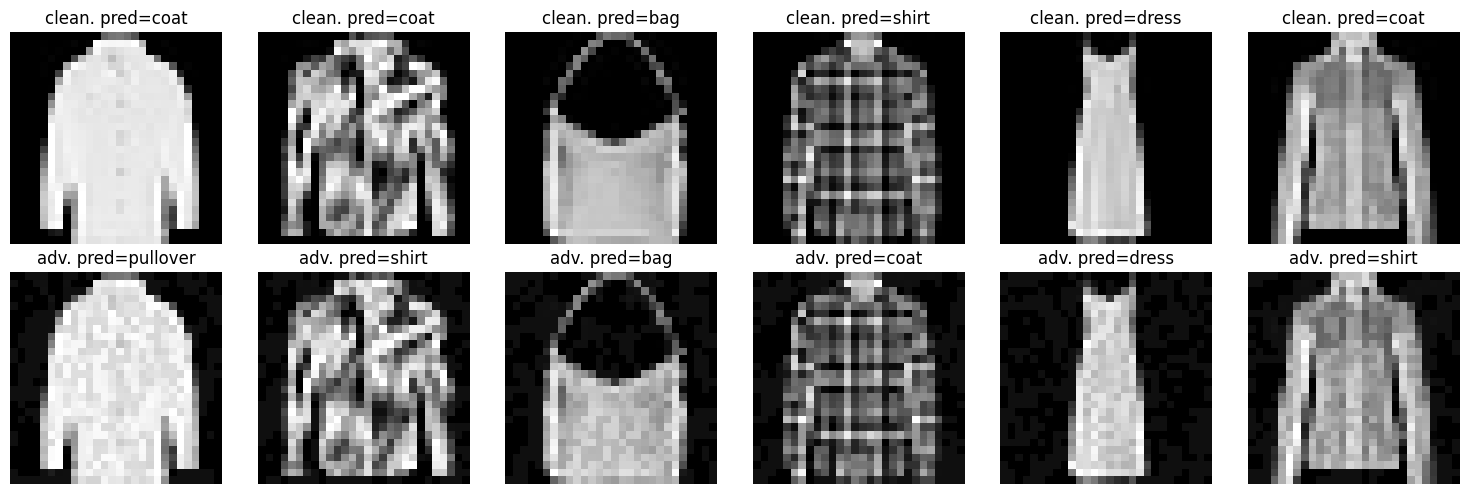

rFGM attack -- eps: 0.08


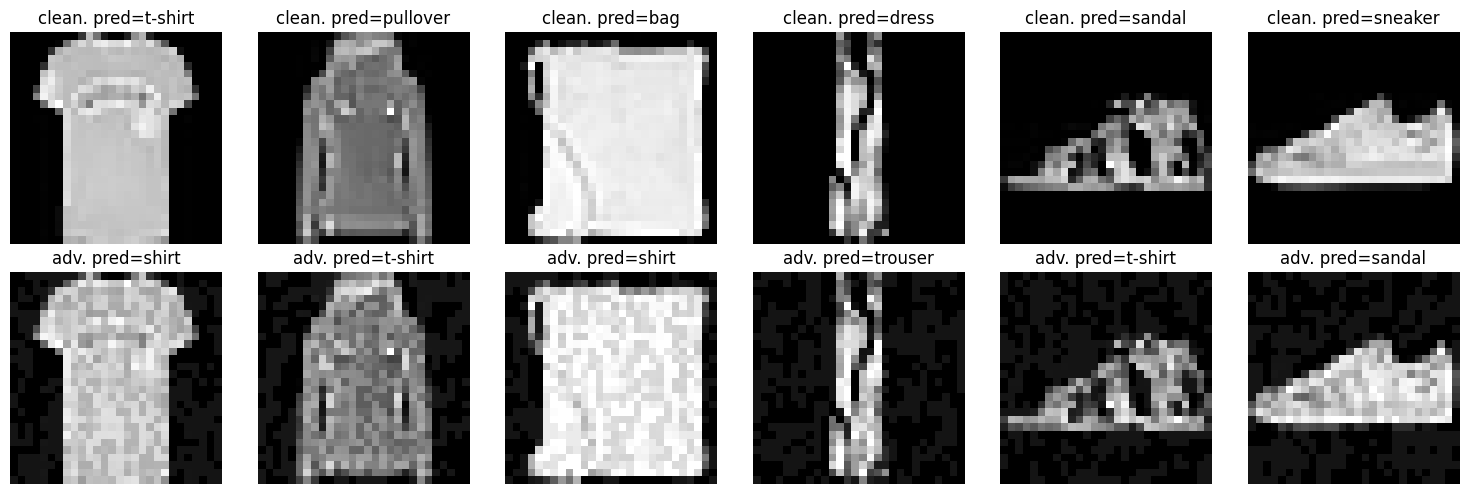

rFGM attack -- eps: 0.1


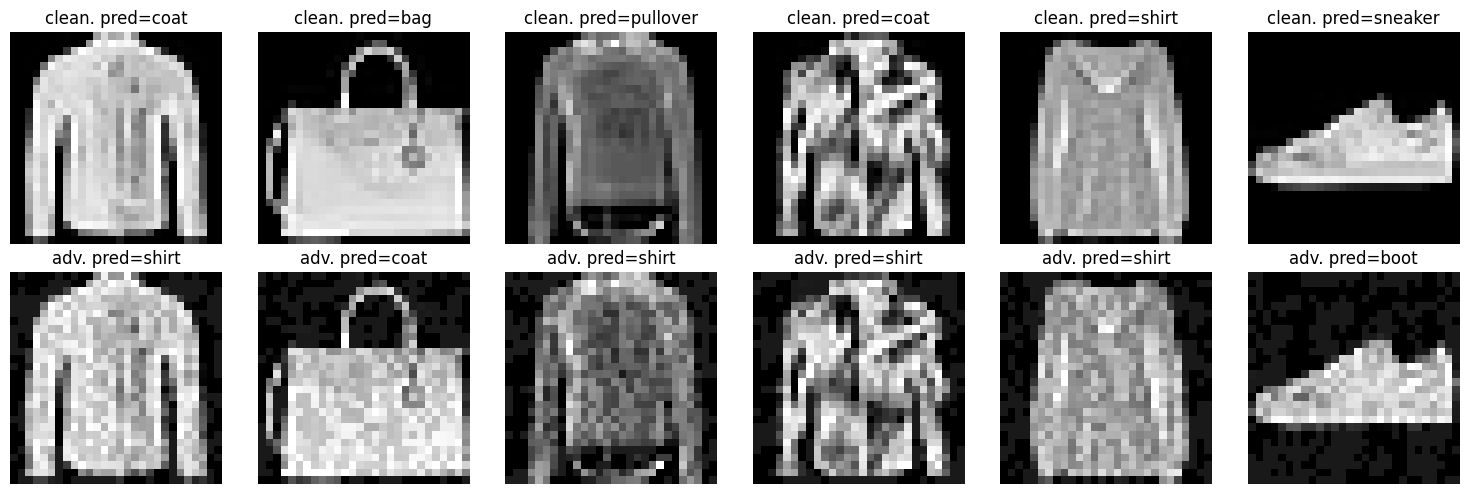

rFGM attack -- eps: 0.12


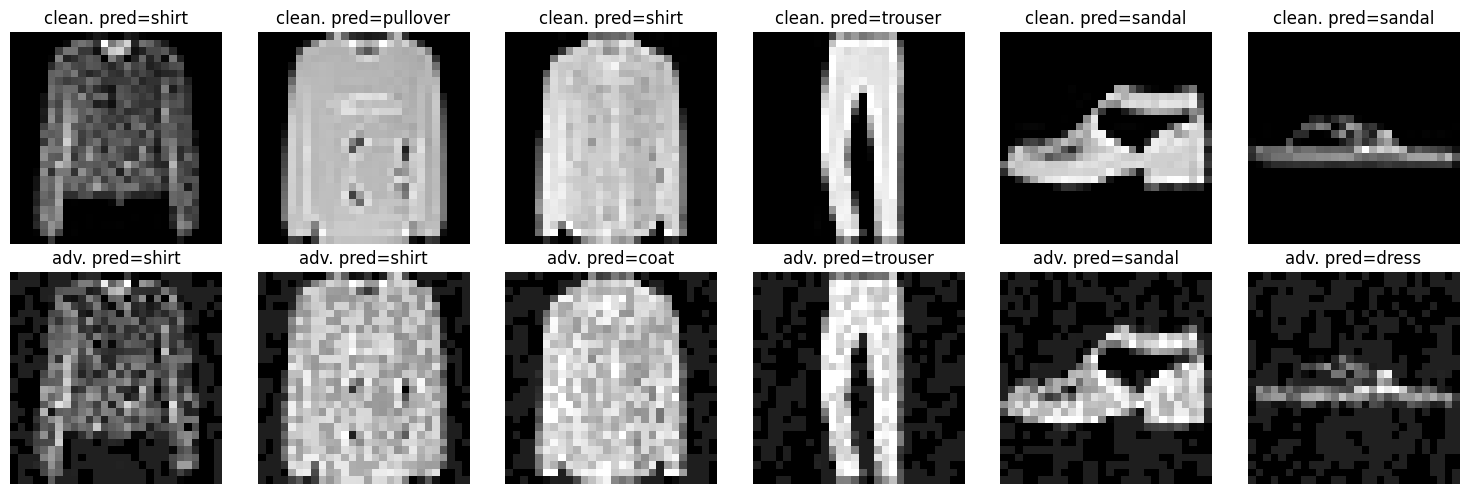

rFGM attack -- eps: 0.14


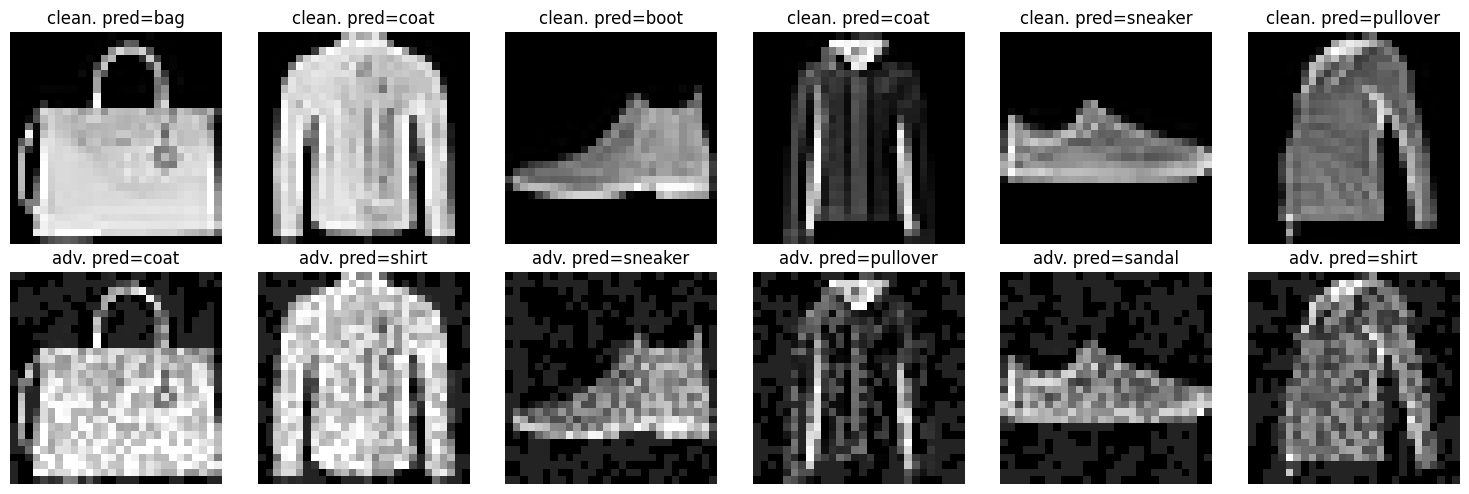

rFGM attack -- eps: 0.16


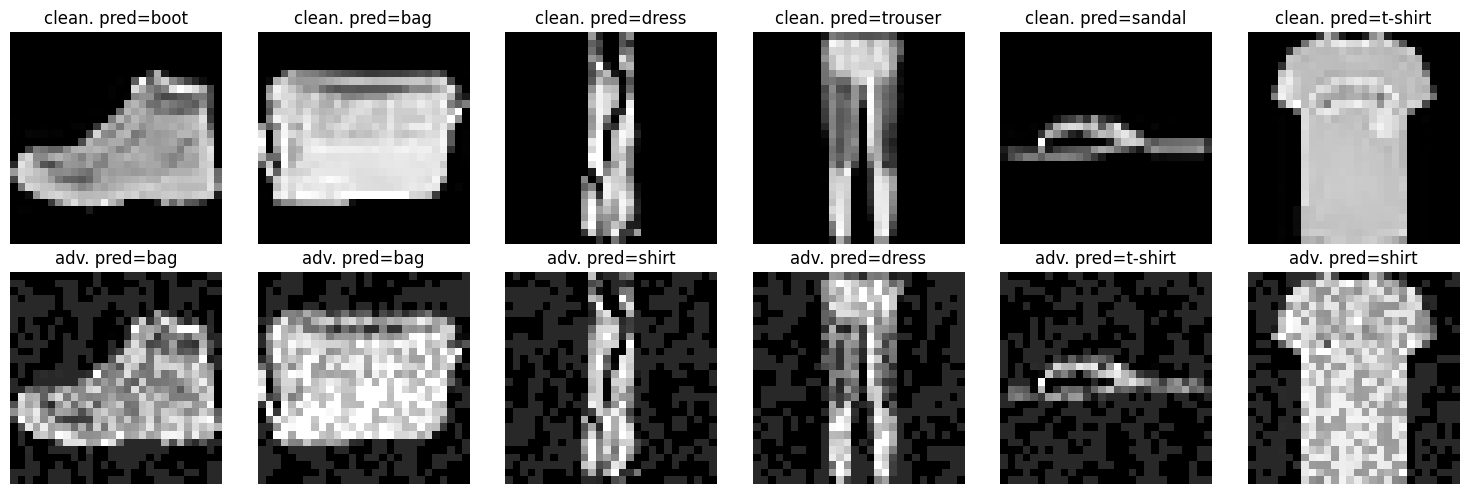

rFGM attack -- eps: 0.18


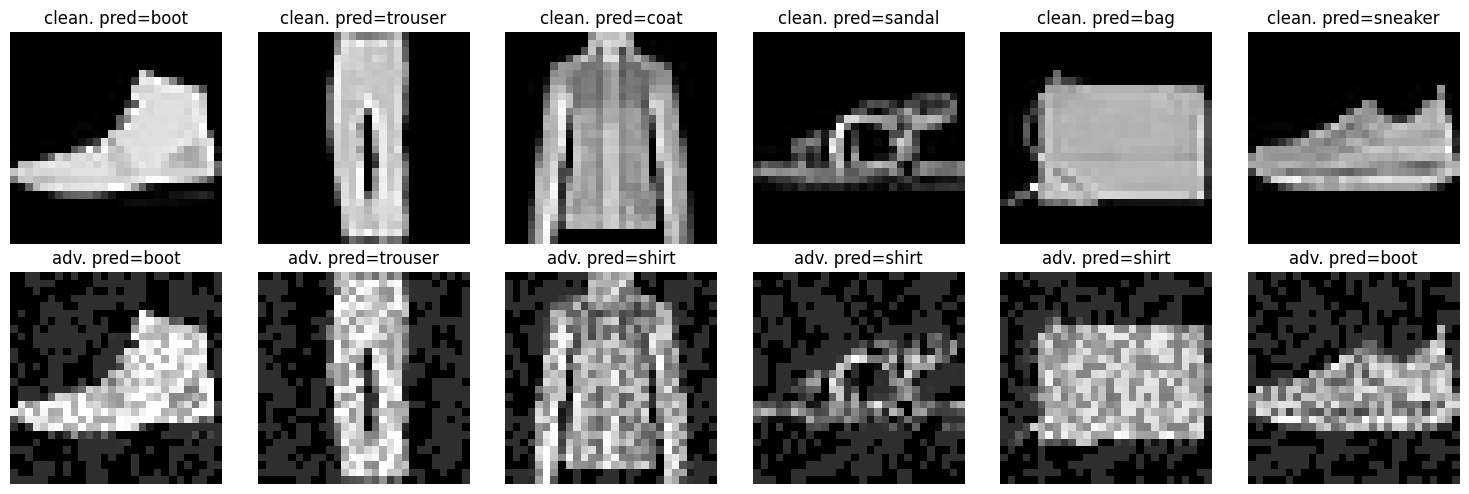

rFGM attack -- eps: 0.2


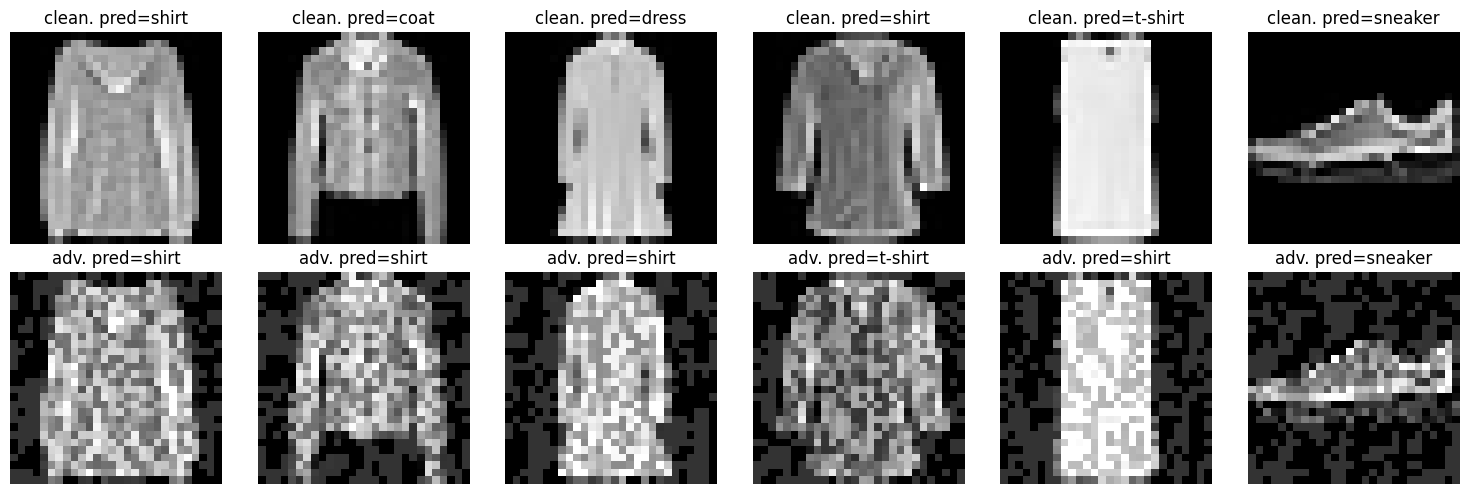

In [24]:
for eps in np.linspace(0,0.2,11):
    print("rFGM attack -- eps:", eps)
    attack_viz(eps, "rFGSM")

FGM L2 attack -- eps: 0.0


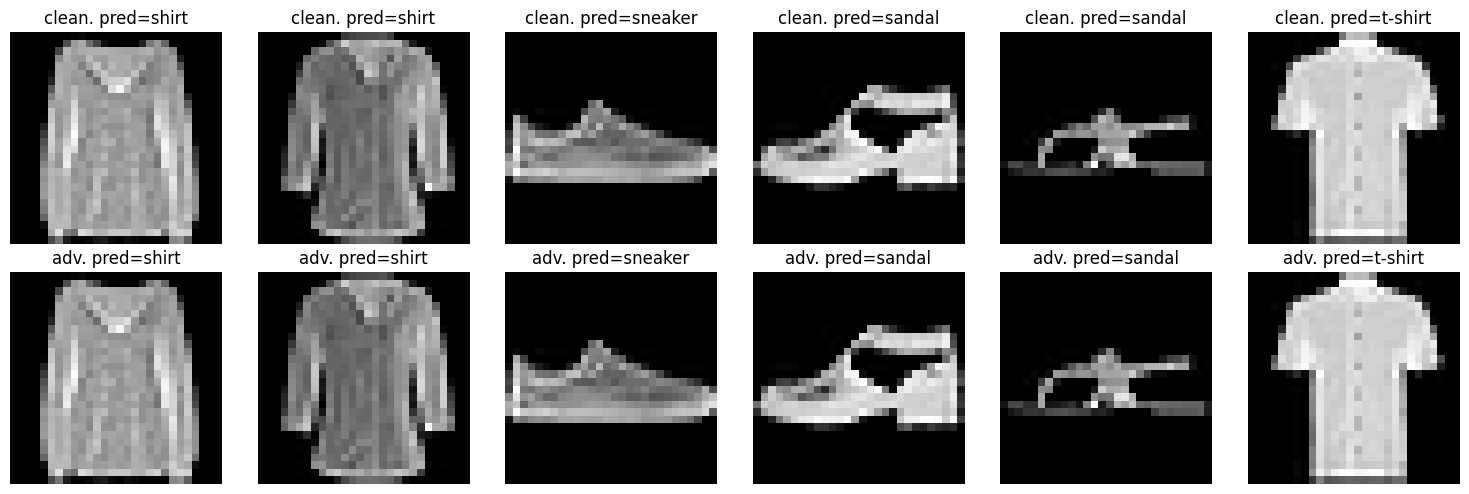

FGM L2 attack -- eps: 0.5


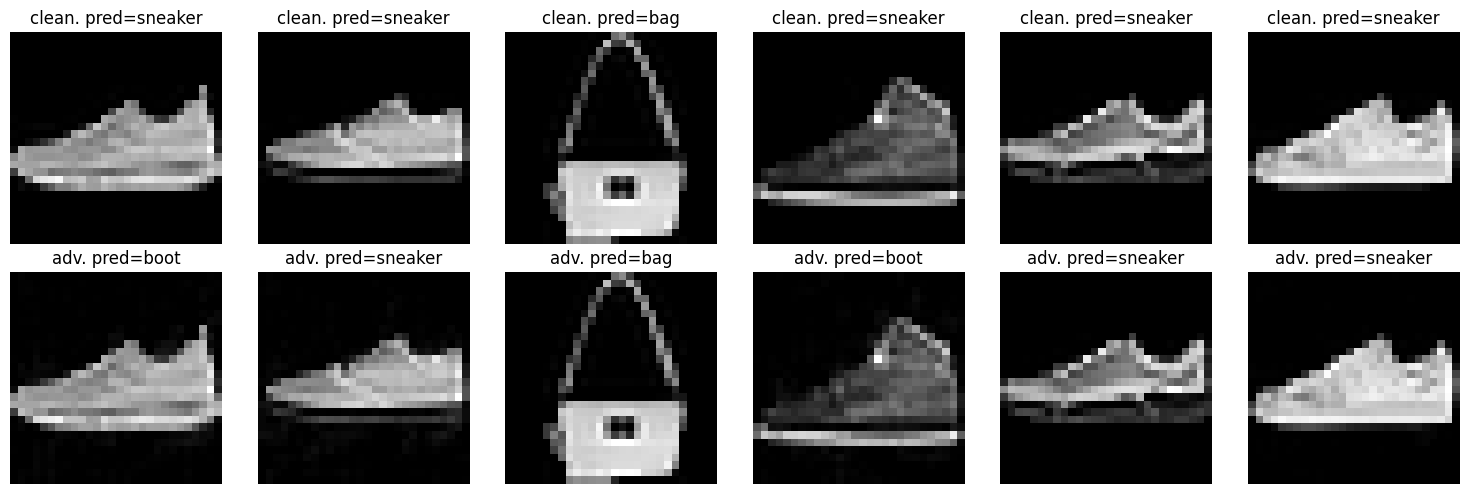

FGM L2 attack -- eps: 1.0


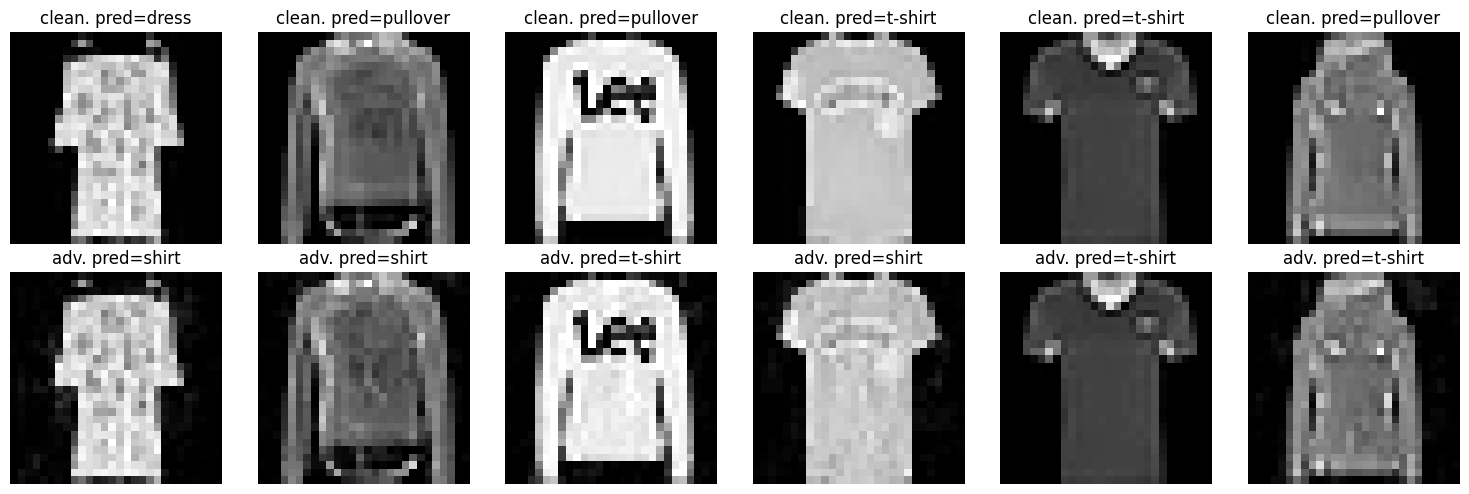

FGM L2 attack -- eps: 1.5


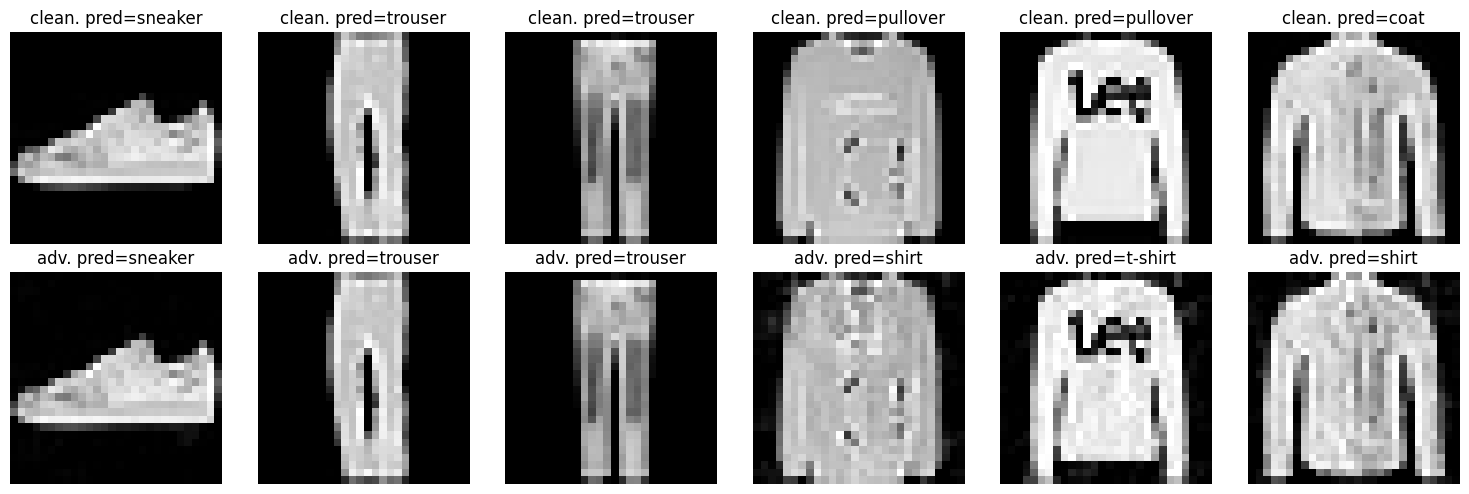

FGM L2 attack -- eps: 2.0


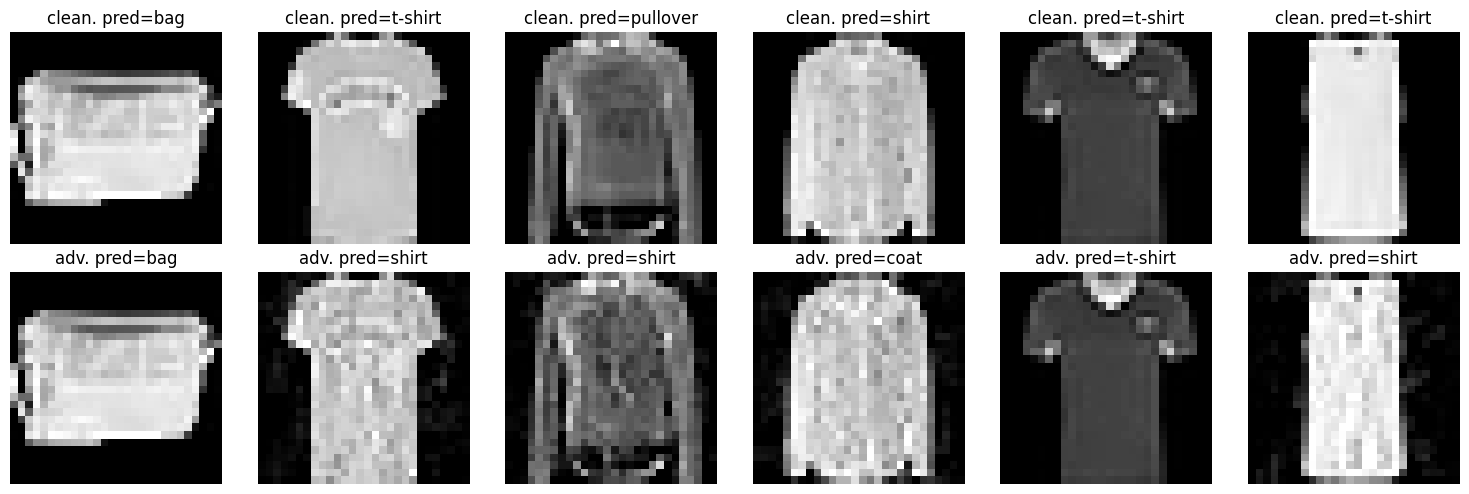

FGM L2 attack -- eps: 2.5


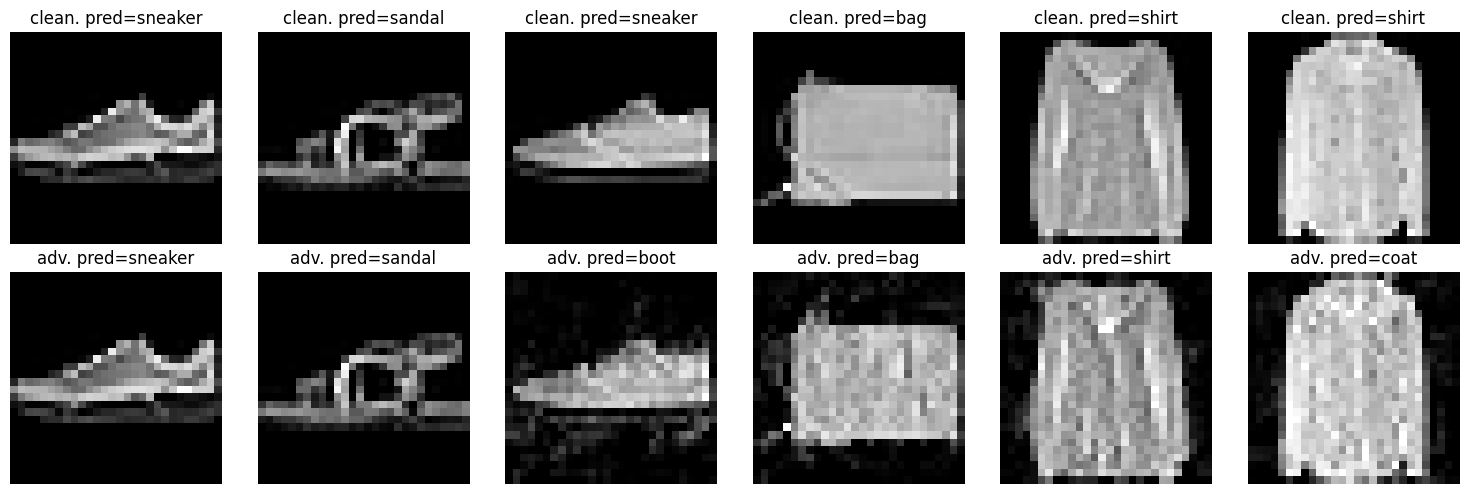

FGM L2 attack -- eps: 3.0


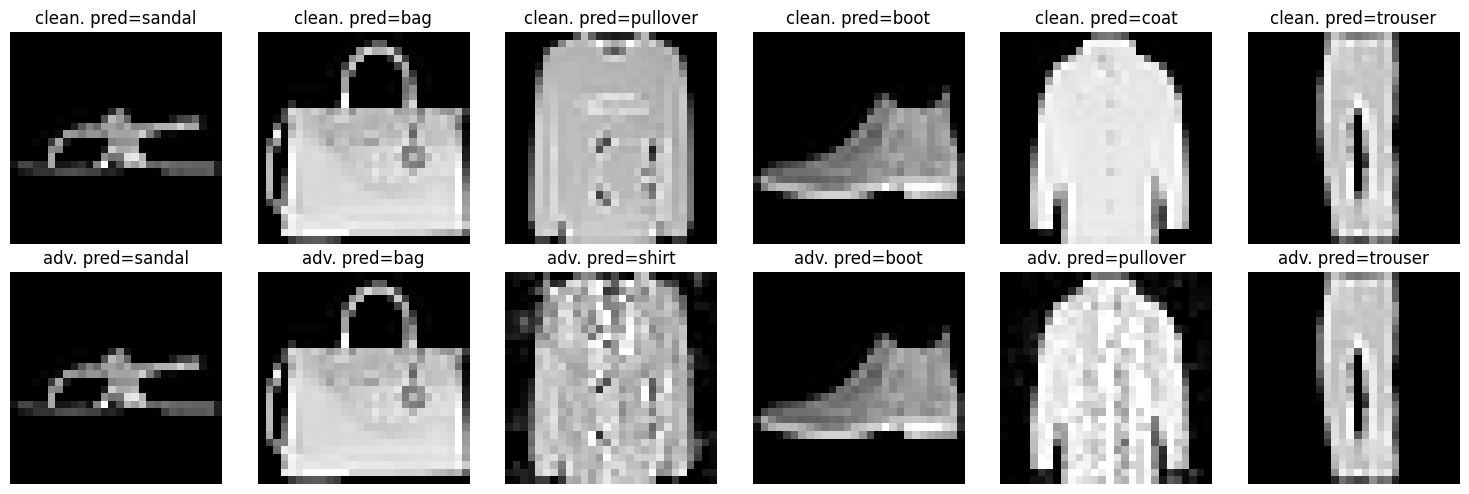

FGM L2 attack -- eps: 3.5


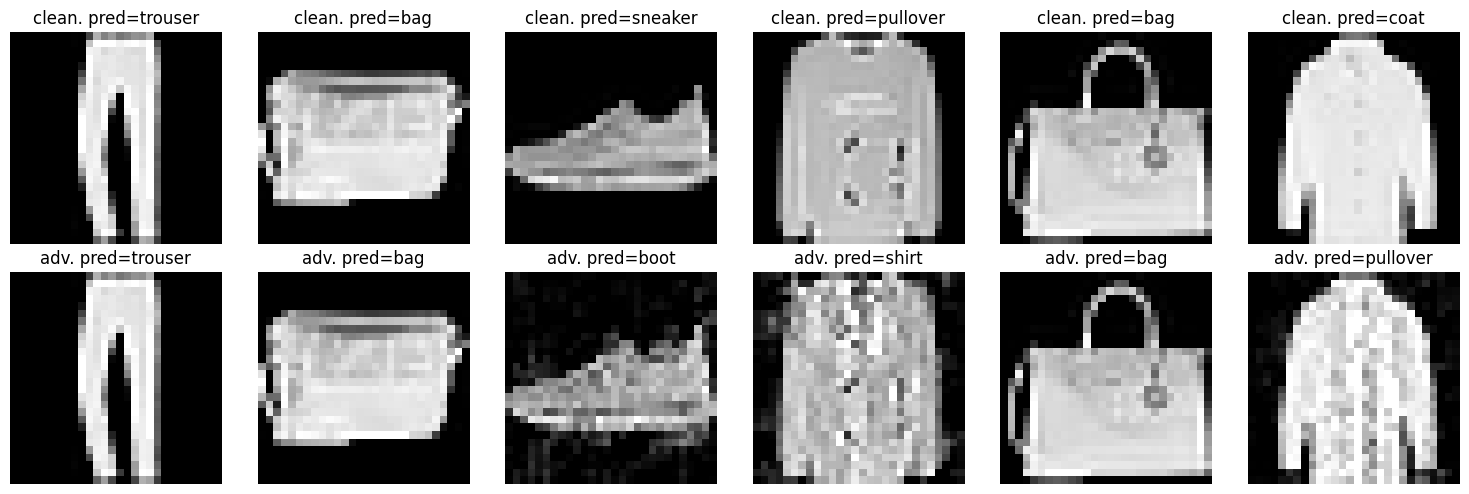

FGM L2 attack -- eps: 4.0


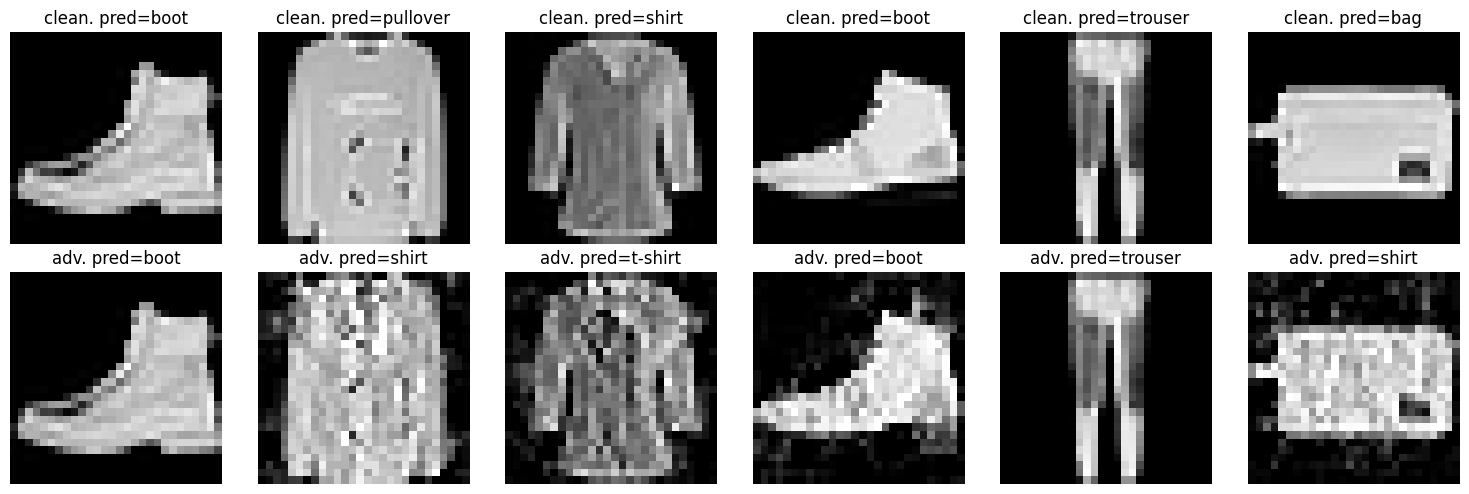

In [28]:
for eps in np.linspace(0,4,9):
    print("FGM L2 attack -- eps:", eps)
    attack_viz(eps, "FGM_L2")

## Lab 2

## Test Attacks - Whitebox & Blackbox

Don't forget to plot accuracy vs. epsilon curves!

### (b)

In [8]:
l_whitebox_acc = []
l_blackbox_acc = []
for eps in np.linspace(0,0.1,11):
    ## Load pretrained models
    whitebox = models.NetA()
    blackbox = models.NetB()

    whitebox.load_state_dict(torch.load('netA_standard.pt')) # TODO
    blackbox.load_state_dict(torch.load('netB_standard.pt')) # TODO

    whitebox = whitebox.to(device); blackbox = blackbox.to(device) 
    whitebox.eval(); blackbox.eval()

    test_acc,_ = test_model(whitebox,test_loader,device)
    print("Initial Accuracy of Whitebox Model: ",test_acc)
    test_acc,_ = test_model(blackbox,test_loader,device)
    print("Initial Accuracy of Blackbox Model: ",test_acc)

    ## Test the models against an adversarial attack

    # TODO: Set attack parameters here
    ATK_EPS = eps
    ATK_ITERS = 10
    ATK_ALPHA = 1.85*(ATK_EPS/ATK_ITERS)

    whitebox_correct = 0.
    blackbox_correct = 0.
    running_total = 0.
    for batch_idx,(data,labels) in enumerate(test_loader):
        data = data.to(device) 
        labels = labels.to(device)

        # TODO: Perform adversarial attack here
        adv_data_white = attacks.random_noise_attack(model=whitebox, dat=data, eps=ATK_EPS, device=device)
        adv_data_black = attacks.random_noise_attack(model=blackbox, dat=data, eps=ATK_EPS, device=device)

        # Sanity checking if adversarial example is "legal"
        assert(torch.max(torch.abs(adv_data_white-data)) <= (ATK_EPS + 1e-5) )
        assert(torch.max(torch.abs(adv_data_black-data)) <= (ATK_EPS + 1e-5) )
        assert(adv_data_white.max() == 1.)
        assert(adv_data_black.max() == 1.)
        assert(adv_data_white.min() == 0.)
        assert(adv_data_black.min() == 0.)
        
        # Compute accuracy on perturbed data
        with torch.no_grad():
            # Stat keeping - whitebox
            whitebox_outputs = whitebox(adv_data_white)
            _,whitebox_preds = whitebox_outputs.max(1)
            whitebox_correct += whitebox_preds.eq(labels).sum().item()
            # Stat keeping - blackbox
            blackbox_outputs = blackbox(adv_data_black)
            _,blackbox_preds = blackbox_outputs.max(1)
            blackbox_correct += blackbox_preds.eq(labels).sum().item()
            running_total += labels.size(0)
        
        # # Plot some samples
        # if batch_idx == 1:
        #     plt.figure(figsize=(15,5))
        #     for jj in range(12):
        #         plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
        #     plt.tight_layout()
        #     plt.show()

    # Print final 
    whitebox_acc = whitebox_correct/running_total
    blackbox_acc = blackbox_correct/running_total

    print("Attack Epsilon: {}; Whitebox Accuracy: {}; Blackbox Accuracy: {}".format(ATK_EPS, whitebox_acc, blackbox_acc))

    # append the accuracy to the list
    l_whitebox_acc.append(whitebox_acc)
    l_blackbox_acc.append(blackbox_acc)

    print("Done!\n")

Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9215
Attack Epsilon: 0.0; Whitebox Accuracy: 0.9225; Blackbox Accuracy: 0.9215
Done!

Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9215
Attack Epsilon: 0.01; Whitebox Accuracy: 0.9212; Blackbox Accuracy: 0.9217
Done!

Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9215
Attack Epsilon: 0.02; Whitebox Accuracy: 0.9207; Blackbox Accuracy: 0.9194
Done!

Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9215
Attack Epsilon: 0.03; Whitebox Accuracy: 0.9198; Blackbox Accuracy: 0.9165
Done!

Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9215
Attack Epsilon: 0.04; Whitebox Accuracy: 0.9166; Blackbox Accuracy: 0.9109
Done!

Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9215
Attack Epsilon: 0.05; Whitebox Accuracy: 0.9134; Blackbox Accur

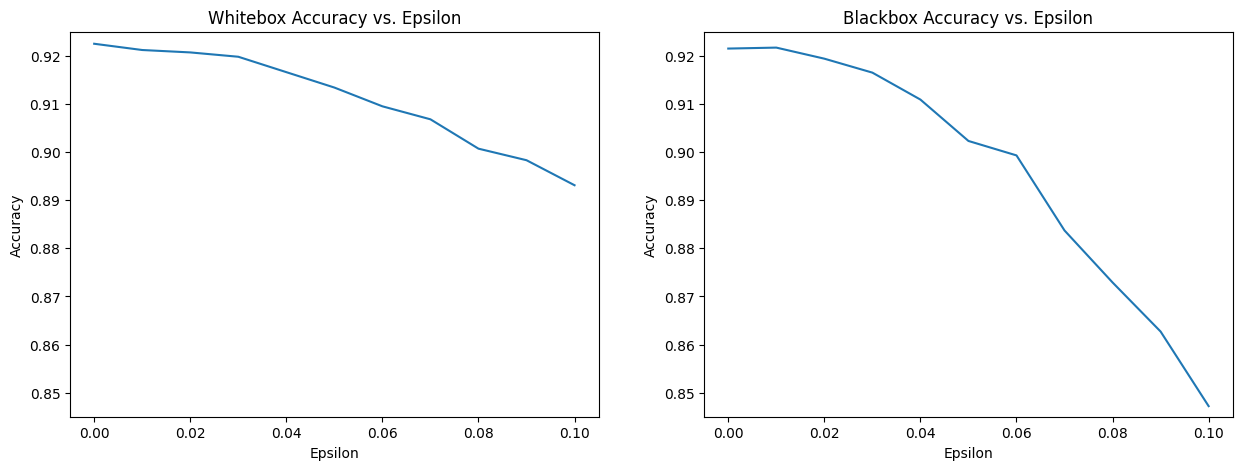

In [15]:
# plot the accuracy vs. epsilon on two subplots for whitebox and blackbox
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.linspace(0,0.1,11), l_whitebox_acc)
plt.ylim(0.845,0.925)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.title("Whitebox Accuracy vs. Epsilon")

plt.subplot(1,2,2)
plt.plot(np.linspace(0,0.1,11), l_blackbox_acc)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.ylim(0.845,0.925)
plt.title("Blackbox Accuracy vs. Epsilon")

plt.show()

### (c)

In [17]:
l_whitebox_acc_FGSM = []
l_blackbox_acc_FGSM = []
for eps in np.linspace(0,0.1,11):
    ## Load pretrained models
    whitebox = models.NetA()
    blackbox = models.NetB()

    whitebox.load_state_dict(torch.load('netA_standard.pt')) # TODO
    blackbox.load_state_dict(torch.load('netB_standard.pt')) # TODO

    whitebox = whitebox.to(device); blackbox = blackbox.to(device) 
    whitebox.eval(); blackbox.eval()

    test_acc,_ = test_model(whitebox,test_loader,device)
    print("Initial Accuracy of Whitebox Model: ",test_acc)
    test_acc,_ = test_model(blackbox,test_loader,device)
    print("Initial Accuracy of Blackbox Model: ",test_acc)

    ## Test the models against an adversarial attack

    # TODO: Set attack parameters here
    ATK_EPS = eps
    ATK_ITERS = 10
    ATK_ALPHA = 1.85*(ATK_EPS/ATK_ITERS)

    whitebox_correct = 0.
    blackbox_correct = 0.
    running_total = 0.
    for batch_idx,(data,labels) in enumerate(test_loader):
        data = data.to(device) 
        labels = labels.to(device)

        # TODO: Perform adversarial attack here
        adv_data = attacks.FGSM_attack(model=whitebox, dat=data, lbl=labels, eps=ATK_EPS, device=device)

        # Sanity checking if adversarial example is "legal"
        assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
        assert(adv_data.max() == 1.)
        assert(adv_data.min() == 0.)
        
        # Compute accuracy on perturbed data
        with torch.no_grad():
            # Stat keeping - whitebox
            whitebox_outputs = whitebox(adv_data)
            _,whitebox_preds = whitebox_outputs.max(1)
            whitebox_correct += whitebox_preds.eq(labels).sum().item()
            # Stat keeping - blackbox
            blackbox_outputs = blackbox(adv_data)
            _,blackbox_preds = blackbox_outputs.max(1)
            blackbox_correct += blackbox_preds.eq(labels).sum().item()
            running_total += labels.size(0)
        
        # # Plot some samples
        # if batch_idx == 1:
        #     plt.figure(figsize=(15,5))
        #     for jj in range(12):
        #         plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
        #     plt.tight_layout()
        #     plt.show()

    # Print final 
    whitebox_acc = whitebox_correct/running_total
    blackbox_acc = blackbox_correct/running_total

    print("Attack Epsilon: {}; Whitebox Accuracy: {}; Blackbox Accuracy: {}".format(ATK_EPS, whitebox_acc, blackbox_acc))

    # append the accuracy to the list
    l_whitebox_acc_FGSM.append(whitebox_acc)
    l_blackbox_acc_FGSM.append(blackbox_acc)

    print("Done!\n")

Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9215
Attack Epsilon: 0.0; Whitebox Accuracy: 0.9225; Blackbox Accuracy: 0.9215
Done!

Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9215
Attack Epsilon: 0.01; Whitebox Accuracy: 0.7092; Blackbox Accuracy: 0.8757
Done!

Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9215
Attack Epsilon: 0.02; Whitebox Accuracy: 0.5769; Blackbox Accuracy: 0.8177
Done!

Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9215
Attack Epsilon: 0.03; Whitebox Accuracy: 0.51; Blackbox Accuracy: 0.7591
Done!

Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9215
Attack Epsilon: 0.04; Whitebox Accuracy: 0.46; Blackbox Accuracy: 0.7007
Done!

Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9215
Attack Epsilon: 0.05; Whitebox Accuracy: 0.4186; Blackbox Accuracy:

In [18]:
l_whitebox_acc_rFGSM = []
l_blackbox_acc_rFGSM = []
for eps in np.linspace(0,0.1,11):
    ## Load pretrained models
    whitebox = models.NetA()
    blackbox = models.NetB()

    whitebox.load_state_dict(torch.load('netA_standard.pt')) # TODO
    blackbox.load_state_dict(torch.load('netB_standard.pt')) # TODO

    whitebox = whitebox.to(device); blackbox = blackbox.to(device) 
    whitebox.eval(); blackbox.eval()

    test_acc,_ = test_model(whitebox,test_loader,device)
    print("Initial Accuracy of Whitebox Model: ",test_acc)
    test_acc,_ = test_model(blackbox,test_loader,device)
    print("Initial Accuracy of Blackbox Model: ",test_acc)

    ## Test the models against an adversarial attack

    # TODO: Set attack parameters here
    ATK_EPS = eps
    ATK_ITERS = 10
    ATK_ALPHA = 1.85*(ATK_EPS/ATK_ITERS)

    whitebox_correct = 0.
    blackbox_correct = 0.
    running_total = 0.
    for batch_idx,(data,labels) in enumerate(test_loader):
        data = data.to(device) 
        labels = labels.to(device)

        # TODO: Perform adversarial attack here
        adv_data = attacks.rFGSM_attack(model=whitebox, dat=data, lbl=labels, eps=ATK_EPS, device=device)

        # Sanity checking if adversarial example is "legal"
        assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
        assert(adv_data.max() == 1.)
        assert(adv_data.min() == 0.)
        
        # Compute accuracy on perturbed data
        with torch.no_grad():
            # Stat keeping - whitebox
            whitebox_outputs = whitebox(adv_data)
            _,whitebox_preds = whitebox_outputs.max(1)
            whitebox_correct += whitebox_preds.eq(labels).sum().item()
            # Stat keeping - blackbox
            blackbox_outputs = blackbox(adv_data)
            _,blackbox_preds = blackbox_outputs.max(1)
            blackbox_correct += blackbox_preds.eq(labels).sum().item()
            running_total += labels.size(0)
        
        # # Plot some samples
        # if batch_idx == 1:
        #     plt.figure(figsize=(15,5))
        #     for jj in range(12):
        #         plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
        #     plt.tight_layout()
        #     plt.show()

    # Print final 
    whitebox_acc = whitebox_correct/running_total
    blackbox_acc = blackbox_correct/running_total

    print("Attack Epsilon: {}; Whitebox Accuracy: {}; Blackbox Accuracy: {}".format(ATK_EPS, whitebox_acc, blackbox_acc))

    # append the accuracy to the list
    l_whitebox_acc_rFGSM.append(whitebox_acc)
    l_blackbox_acc_rFGSM.append(blackbox_acc)

    print("Done!\n")

Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9215
Attack Epsilon: 0.0; Whitebox Accuracy: 0.9225; Blackbox Accuracy: 0.9215
Done!

Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9215
Attack Epsilon: 0.01; Whitebox Accuracy: 0.7506; Blackbox Accuracy: 0.8862
Done!

Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9215
Attack Epsilon: 0.02; Whitebox Accuracy: 0.6029; Blackbox Accuracy: 0.836
Done!

Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9215
Attack Epsilon: 0.03; Whitebox Accuracy: 0.5322; Blackbox Accuracy: 0.7772
Done!

Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9215
Attack Epsilon: 0.04; Whitebox Accuracy: 0.4724; Blackbox Accuracy: 0.7161
Done!

Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9215
Attack Epsilon: 0.05; Whitebox Accuracy: 0.424; Blackbox Accurac

In [19]:
l_whitebox_acc_PGD = []
l_blackbox_acc_PGD = []
for eps in np.linspace(0,0.1,11):
    ## Load pretrained models
    whitebox = models.NetA()
    blackbox = models.NetB()

    whitebox.load_state_dict(torch.load('netA_standard.pt')) # TODO
    blackbox.load_state_dict(torch.load('netB_standard.pt')) # TODO

    whitebox = whitebox.to(device); blackbox = blackbox.to(device) 
    whitebox.eval(); blackbox.eval()

    test_acc,_ = test_model(whitebox,test_loader,device)
    print("Initial Accuracy of Whitebox Model: ",test_acc)
    test_acc,_ = test_model(blackbox,test_loader,device)
    print("Initial Accuracy of Blackbox Model: ",test_acc)

    ## Test the models against an adversarial attack

    # TODO: Set attack parameters here
    ATK_EPS = eps
    ATK_ITERS = 10
    ATK_ALPHA = 1.85*(ATK_EPS/ATK_ITERS)

    whitebox_correct = 0.
    blackbox_correct = 0.
    running_total = 0.
    for batch_idx,(data,labels) in enumerate(test_loader):
        data = data.to(device) 
        labels = labels.to(device)

        # TODO: Perform adversarial attack here
        adv_data = attacks.PGD_attack(model=whitebox, dat=data, lbl=labels, eps=ATK_EPS, alpha=ATK_ALPHA, iters=ATK_ITERS, device=device, rand_start=True)

        # Sanity checking if adversarial example is "legal"
        assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
        assert(adv_data.max() == 1.)
        assert(adv_data.min() == 0.)
        
        # Compute accuracy on perturbed data
        with torch.no_grad():
            # Stat keeping - whitebox
            whitebox_outputs = whitebox(adv_data)
            _,whitebox_preds = whitebox_outputs.max(1)
            whitebox_correct += whitebox_preds.eq(labels).sum().item()
            # Stat keeping - blackbox
            blackbox_outputs = blackbox(adv_data)
            _,blackbox_preds = blackbox_outputs.max(1)
            blackbox_correct += blackbox_preds.eq(labels).sum().item()
            running_total += labels.size(0)
        
        # # Plot some samples
        # if batch_idx == 1:
        #     plt.figure(figsize=(15,5))
        #     for jj in range(12):
        #         plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
        #     plt.tight_layout()
        #     plt.show()

    # Print final 
    whitebox_acc = whitebox_correct/running_total
    blackbox_acc = blackbox_correct/running_total

    print("Attack Epsilon: {}; Whitebox Accuracy: {}; Blackbox Accuracy: {}".format(ATK_EPS, whitebox_acc, blackbox_acc))

    # append the accuracy to the list
    l_whitebox_acc_PGD.append(whitebox_acc)
    l_blackbox_acc_PGD.append(blackbox_acc)

    print("Done!\n")

Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9215
Attack Epsilon: 0.0; Whitebox Accuracy: 0.9225; Blackbox Accuracy: 0.9215
Done!

Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9215
Attack Epsilon: 0.01; Whitebox Accuracy: 0.6563; Blackbox Accuracy: 0.8724
Done!

Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9215
Attack Epsilon: 0.02; Whitebox Accuracy: 0.417; Blackbox Accuracy: 0.7979
Done!

Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9215
Attack Epsilon: 0.03; Whitebox Accuracy: 0.2675; Blackbox Accuracy: 0.7134
Done!

Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9215
Attack Epsilon: 0.04; Whitebox Accuracy: 0.1643; Blackbox Accuracy: 0.6325
Done!

Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9215
Attack Epsilon: 0.05; Whitebox Accuracy: 0.0989; Blackbox Accura

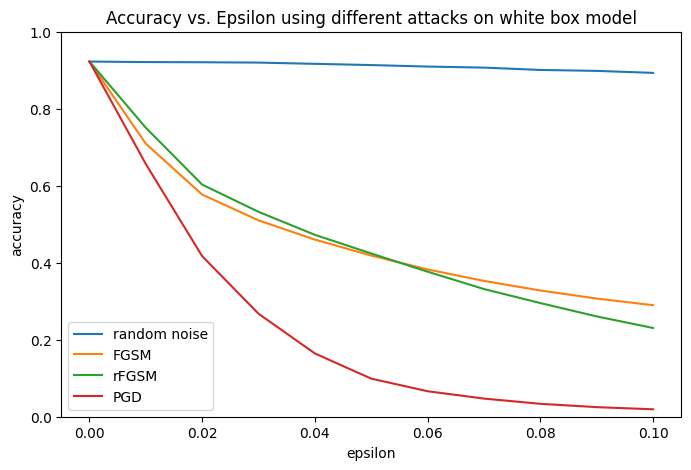

In [22]:
# plot the 4 attacks of white box model
plt.figure(figsize=(8,5))
plt.plot(np.linspace(0,0.1,11), l_whitebox_acc, label="random noise")
plt.plot(np.linspace(0,0.1,11), l_whitebox_acc_FGSM, label="FGSM")
plt.plot(np.linspace(0,0.1,11), l_whitebox_acc_rFGSM, label="rFGSM")
plt.plot(np.linspace(0,0.1,11), l_whitebox_acc_PGD, label="PGD")
plt.xlabel("epsilon")
plt.ylabel("accuracy")
plt.ylim(0,1)
plt.title("Accuracy vs. Epsilon using different attacks on white box model")
plt.legend()
plt.show()

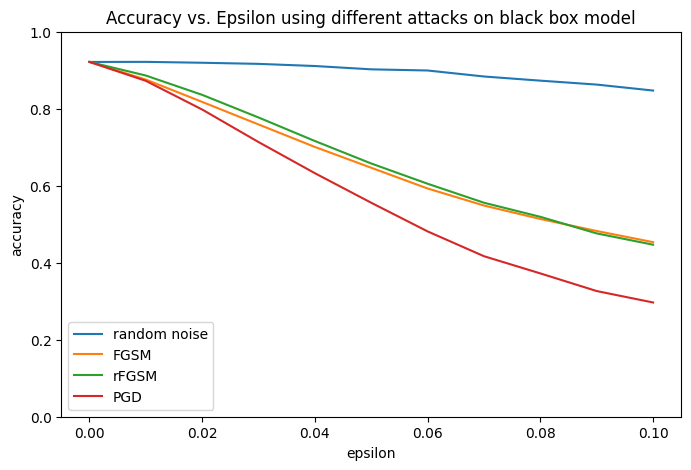

In [23]:
# plot the 4 attacks of black box model
plt.figure(figsize=(8,5))
plt.plot(np.linspace(0,0.1,11), l_blackbox_acc, label="random noise")
plt.plot(np.linspace(0,0.1,11), l_blackbox_acc_FGSM, label="FGSM")
plt.plot(np.linspace(0,0.1,11), l_blackbox_acc_rFGSM, label="rFGSM")
plt.plot(np.linspace(0,0.1,11), l_blackbox_acc_PGD, label="PGD")
plt.xlabel("epsilon")
plt.ylabel("accuracy")
plt.ylim(0,1)
plt.title("Accuracy vs. Epsilon using different attacks on black box model")
plt.legend()
plt.show()

## Test Robust Models

Don't forget to plot accuracy vs. epsilon curves!

### (a)

FGSM attack, eps = 0.1

In [26]:
## Pick a model architecture
net = models.NetA().to(device)

## Checkpoint name for this model
model_checkpoint = "netA_advtrain_fgsm0p1.pt"

## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

## Training Loop
l_test_acc_fgsm0p1 = []
l_test_loss_fgsm0p1 = []
for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)

        # adversarial training
        data = attacks.FGSM_attack(model=net, dat=data, lbl=labels, eps=0.1, device=device)
        
        # Forward pass
        outputs = net(data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)
        
    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    l_test_acc_fgsm0p1.append(test_acc)
    l_test_loss_fgsm0p1.append(test_loss)
    # Save model    
    torch.save(net.state_dict(), model_checkpoint)
    
    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.65560; TrainLoss: 0.84687; TestAcc: 0.80140; TestLoss: 0.49740
Epoch: [ 1 / 20 ]; TrainAcc: 0.73135; TrainLoss: 0.66696; TestAcc: 0.79820; TestLoss: 0.51028
Epoch: [ 2 / 20 ]; TrainAcc: 0.84582; TrainLoss: 0.44655; TestAcc: 0.79750; TestLoss: 0.51556
Epoch: [ 3 / 20 ]; TrainAcc: 0.94267; TrainLoss: 0.17576; TestAcc: 0.62760; TestLoss: 1.44996
Epoch: [ 4 / 20 ]; TrainAcc: 0.90283; TrainLoss: 0.26898; TestAcc: 0.69890; TestLoss: 0.71158
Epoch: [ 5 / 20 ]; TrainAcc: 0.92708; TrainLoss: 0.21482; TestAcc: 0.79960; TestLoss: 0.50110
Epoch: [ 6 / 20 ]; TrainAcc: 0.86857; TrainLoss: 0.34555; TestAcc: 0.78220; TestLoss: 0.54174
Epoch: [ 7 / 20 ]; TrainAcc: 0.78348; TrainLoss: 0.54653; TestAcc: 0.71500; TestLoss: 0.89504
Epoch: [ 8 / 20 ]; TrainAcc: 0.73297; TrainLoss: 0.67346; TestAcc: 0.81550; TestLoss: 0.48852
Epoch: [ 9 / 20 ]; TrainAcc: 0.73573; TrainLoss: 0.65755; TestAcc: 0.82080; TestLoss: 0.44613
Epoch: [ 10 / 20 ]; TrainAcc: 0.76663; TrainLoss: 0.59104; T

rFGSM attack, eps = 0.1

In [25]:
## Pick a model architecture
net = models.NetA().to(device)

## Checkpoint name for this model
model_checkpoint = "netA_advtrain_rfgsm0p1.pt"

## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

## Training Loop
l_test_acc_rfgsm0p1 = []
l_test_loss_rfgsm0p1 = []

for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)

        # adversarial training
        data = attacks.rFGSM_attack(model=net, dat=data, lbl=labels, eps=0.1, device=device)
        
        # Forward pass
        outputs = net(data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)
        
    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    l_test_acc_rfgsm0p1.append(test_acc)
    l_test_loss_rfgsm0p1.append(test_loss)
    
    # Save model    
    torch.save(net.state_dict(), model_checkpoint)
    
    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.68165; TrainLoss: 0.79022; TestAcc: 0.81820; TestLoss: 0.47553
Epoch: [ 1 / 20 ]; TrainAcc: 0.75087; TrainLoss: 0.62077; TestAcc: 0.84770; TestLoss: 0.40646
Epoch: [ 2 / 20 ]; TrainAcc: 0.76725; TrainLoss: 0.57889; TestAcc: 0.85440; TestLoss: 0.38906
Epoch: [ 3 / 20 ]; TrainAcc: 0.77728; TrainLoss: 0.55257; TestAcc: 0.84420; TestLoss: 0.39039
Epoch: [ 4 / 20 ]; TrainAcc: 0.78857; TrainLoss: 0.52619; TestAcc: 0.86040; TestLoss: 0.36994
Epoch: [ 5 / 20 ]; TrainAcc: 0.79528; TrainLoss: 0.50528; TestAcc: 0.86700; TestLoss: 0.34801
Epoch: [ 6 / 20 ]; TrainAcc: 0.80303; TrainLoss: 0.48688; TestAcc: 0.86440; TestLoss: 0.35431
Epoch: [ 7 / 20 ]; TrainAcc: 0.80843; TrainLoss: 0.47216; TestAcc: 0.86480; TestLoss: 0.35497
Epoch: [ 8 / 20 ]; TrainAcc: 0.81323; TrainLoss: 0.46086; TestAcc: 0.86670; TestLoss: 0.34588
Epoch: [ 9 / 20 ]; TrainAcc: 0.81720; TrainLoss: 0.45080; TestAcc: 0.86770; TestLoss: 0.34435
Epoch: [ 10 / 20 ]; TrainAcc: 0.81878; TrainLoss: 0.44495; T

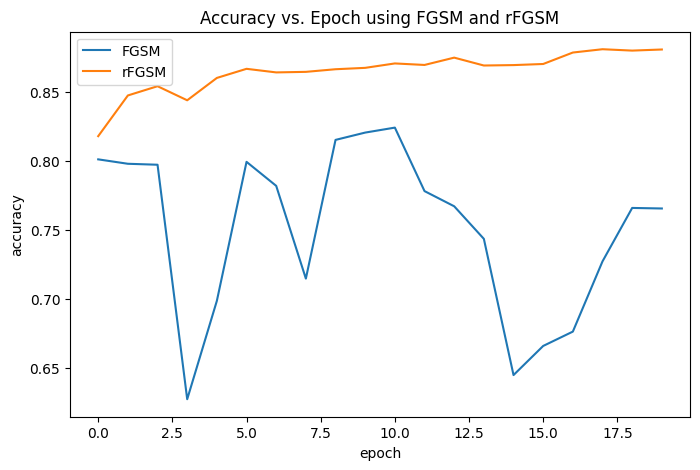

In [27]:
# plot the accuracy vs. epoch of FGSM and rFGSM
plt.figure(figsize=(8,5))
plt.plot(range(20), l_test_acc_fgsm0p1, label="FGSM")
plt.plot(range(20), l_test_acc_rfgsm0p1, label="rFGSM")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy vs. Epoch using FGSM and rFGSM")
plt.legend()
plt.show()

(b)

In [28]:
## Pick a model architecture
net = models.NetA().to(device)

## Checkpoint name for this model
model_checkpoint = "netA_advtrain_pgd0p1.pt"

## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

## Training Loop
l_test_acc_pgd0p1 = []
l_test_loss_pgd0p1 = []

for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)

        # adversarial training
        # ε = 0.1, perturb_iters = 4, α = 1.85 ∗ (ε/perturb_iters)
        EPS = 0.1
        ITE = 4
        ALPHA = 1.85*(EPS/ITE)
        data = attacks.PGD_attack(model=net, dat=data, lbl=labels, eps=EPS, alpha=ALPHA, iters=ITE, device=device, rand_start=True)
        
        # Forward pass
        outputs = net(data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)
        
    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    l_test_acc_pgd0p1.append(test_acc)
    l_test_loss_pgd0p1.append(test_loss)
    
    # Save model    
    torch.save(net.state_dict(), model_checkpoint)
    
    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.63873; TrainLoss: 0.88699; TestAcc: 0.80700; TestLoss: 0.50654
Epoch: [ 1 / 20 ]; TrainAcc: 0.70450; TrainLoss: 0.72192; TestAcc: 0.81280; TestLoss: 0.46623
Epoch: [ 2 / 20 ]; TrainAcc: 0.72718; TrainLoss: 0.67108; TestAcc: 0.83880; TestLoss: 0.43757
Epoch: [ 3 / 20 ]; TrainAcc: 0.74550; TrainLoss: 0.62660; TestAcc: 0.83670; TestLoss: 0.42336
Epoch: [ 4 / 20 ]; TrainAcc: 0.76060; TrainLoss: 0.59339; TestAcc: 0.84690; TestLoss: 0.43280
Epoch: [ 5 / 20 ]; TrainAcc: 0.76938; TrainLoss: 0.57012; TestAcc: 0.83970; TestLoss: 0.41690
Epoch: [ 6 / 20 ]; TrainAcc: 0.77525; TrainLoss: 0.55574; TestAcc: 0.85070; TestLoss: 0.39216
Epoch: [ 7 / 20 ]; TrainAcc: 0.78007; TrainLoss: 0.54480; TestAcc: 0.85230; TestLoss: 0.38845
Epoch: [ 8 / 20 ]; TrainAcc: 0.78188; TrainLoss: 0.53729; TestAcc: 0.85450; TestLoss: 0.38809
Epoch: [ 9 / 20 ]; TrainAcc: 0.78587; TrainLoss: 0.52901; TestAcc: 0.85130; TestLoss: 0.39063
Epoch: [ 10 / 20 ]; TrainAcc: 0.78717; TrainLoss: 0.52266; T

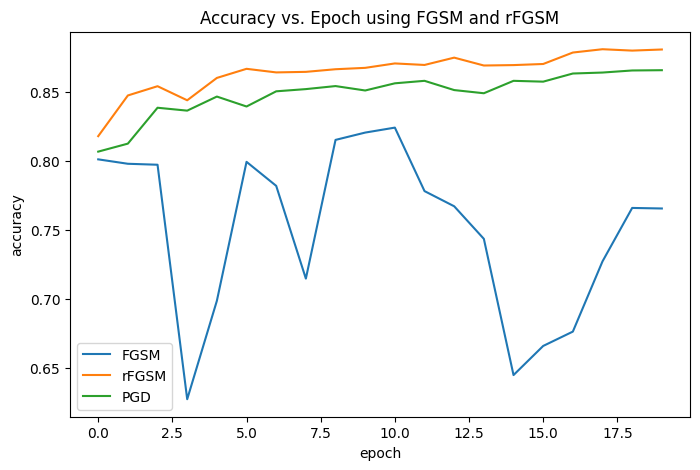

In [29]:
# plot the accuracy vs. epoch of FGSM, rFGSM and PGD
plt.figure(figsize=(8,5))
plt.plot(range(20), l_test_acc_fgsm0p1, label="FGSM")
plt.plot(range(20), l_test_acc_rfgsm0p1, label="rFGSM")
plt.plot(range(20), l_test_acc_pgd0p1, label="PGD")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy vs. Epoch using FGSM and rFGSM")
plt.legend()
plt.show()

(c)

In [4]:
def whitebox_attack(model_name, attack_type, eps, ite, alpha):
    whitebox = models.NetA()
    whitebox.load_state_dict(torch.load(model_name)) # TODO: Load your robust models
    whitebox = whitebox.to(device)
    whitebox.eval(); 

    test_acc,_ = test_model(whitebox,test_loader,device)
    print("Initial Accuracy of Whitebox Model: ",test_acc)

    ## Test the model against an adversarial attack

    # TODO: Set attack parameters here
    ATK_EPS = eps
    ATK_ITERS = ite
    ATK_ALPHA = alpha

    whitebox_correct = 0.
    running_total = 0.
    for batch_idx,(data,labels) in enumerate(test_loader):
        data = data.to(device) 
        labels = labels.to(device)

        # TODO: Perform adversarial attack here
        if attack_type == "FGSM":
            adv_data = attacks.FGSM_attack(model=whitebox, dat=data, lbl=labels, eps=ATK_EPS, device=device)
        elif attack_type == "rFGSM":
            adv_data = attacks.rFGSM_attack(model=whitebox, dat=data, lbl=labels, eps=ATK_EPS, device=device)
        elif attack_type == "PGD":
            adv_data = attacks.PGD_attack(model=whitebox, dat=data, lbl=labels, eps=ATK_EPS, alpha=ATK_ALPHA, iters=ATK_ITERS, device=device, rand_start=True)
        
        # Sanity checking if adversarial example is "legal"
        assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
        assert(adv_data.max() == 1.)
        assert(adv_data.min() == 0.)
        
        # Compute accuracy on perturbed data
        with torch.no_grad():
            whitebox_outputs = whitebox(adv_data)
            _,whitebox_preds = whitebox_outputs.max(1)
            whitebox_correct += whitebox_preds.eq(labels).sum().item()
            running_total += labels.size(0)
        
        # # Plot some samples
        # if batch_idx == 1:
        #     plt.figure(figsize=(15,5))
        #     for jj in range(12):
        #         plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
        #     plt.tight_layout()
        #     plt.show()

    # Print final 
    whitebox_acc = whitebox_correct/running_total
    print("Attack Epsilon: {}; Whitebox Accuracy: {}".format(ATK_EPS, whitebox_acc))

    print("Done!")
    return whitebox_acc

fgsm0p1, ε = [0.0, 0.02, 0.04, . . . , 0.14]

In [5]:
l_white_acc_fgsm = []
for i in ["FGSM", "rFGSM", "PGD"]:
    acc_eps=[]
    for j in np.arange(0,0.14,0.02):
        eps=j
        ite=10
        alp=1.85*(eps/ite)
        acc = whitebox_attack("netA_advtrain_fgsm0p1.pt", i, eps, ite, alp)
        acc_eps.append(acc)
    l_white_acc_fgsm.append(acc_eps)

Initial Accuracy of Whitebox Model:  0.7658
Attack Epsilon: 0.0; Whitebox Accuracy: 0.7658
Done!
Initial Accuracy of Whitebox Model:  0.7658
Attack Epsilon: 0.02; Whitebox Accuracy: 0.704
Done!
Initial Accuracy of Whitebox Model:  0.7658
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8491
Done!
Initial Accuracy of Whitebox Model:  0.7658
Attack Epsilon: 0.06; Whitebox Accuracy: 0.9492
Done!
Initial Accuracy of Whitebox Model:  0.7658
Attack Epsilon: 0.08; Whitebox Accuracy: 0.9699
Done!
Initial Accuracy of Whitebox Model:  0.7658
Attack Epsilon: 0.1; Whitebox Accuracy: 0.9734
Done!
Initial Accuracy of Whitebox Model:  0.7658
Attack Epsilon: 0.12; Whitebox Accuracy: 0.9692
Done!
Initial Accuracy of Whitebox Model:  0.7658
Attack Epsilon: 0.14; Whitebox Accuracy: 0.9545
Done!
Initial Accuracy of Whitebox Model:  0.7658
Attack Epsilon: 0.0; Whitebox Accuracy: 0.7658
Done!
Initial Accuracy of Whitebox Model:  0.7658
Attack Epsilon: 0.02; Whitebox Accuracy: 0.6258
Done!
Initial Accuracy of Whit

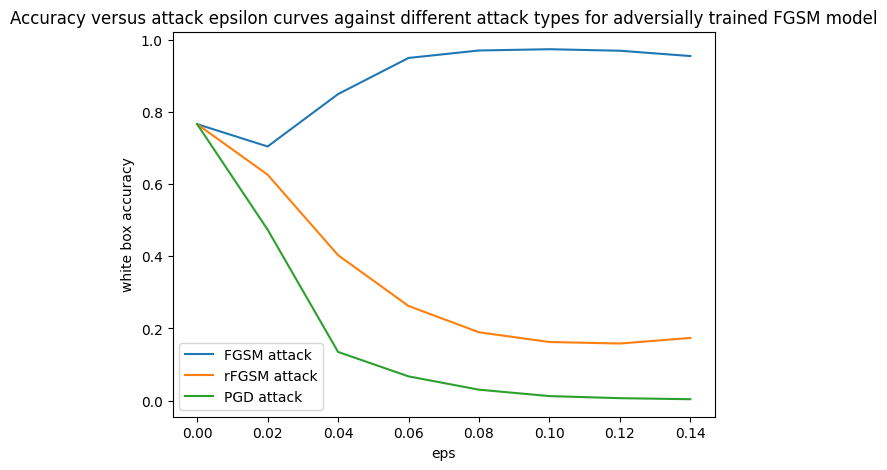

In [6]:
# plot the l_white_acc_fgsm
plt.figure(figsize=(7,5))
plt.plot(np.arange(0,0.14,0.02),l_white_acc_fgsm[0],label="FGSM attack")
plt.plot(np.arange(0,0.14,0.02),l_white_acc_fgsm[1],label="rFGSM attack")
plt.plot(np.arange(0,0.14,0.02),l_white_acc_fgsm[2],label="PGD attack")
plt.xlabel("eps")
plt.ylabel("white box accuracy")
plt.title("Accuracy versus attack epsilon curves against different attack types for adversially trained FGSM model")
plt.legend()
plt.show()

rFGSM, ε = [0.0, 0.02, 0.04, . . . , 0.14]

In [7]:
l_white_acc_rfgsm = []
for i in ["FGSM", "rFGSM", "PGD"]:
    acc_eps=[]
    for j in np.arange(0,0.14,0.02):
        eps=j
        ite=10
        alp=1.85*(eps/ite)
        acc = whitebox_attack("netA_advtrain_rfgsm0p1.pt", i, eps, ite, alp)
        acc_eps.append(acc)
    l_white_acc_rfgsm.append(acc_eps)

Initial Accuracy of Whitebox Model:  0.881
Attack Epsilon: 0.0; Whitebox Accuracy: 0.881
Done!
Initial Accuracy of Whitebox Model:  0.881
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8596
Done!
Initial Accuracy of Whitebox Model:  0.881
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8446
Done!
Initial Accuracy of Whitebox Model:  0.881
Attack Epsilon: 0.06; Whitebox Accuracy: 0.8306
Done!
Initial Accuracy of Whitebox Model:  0.881
Attack Epsilon: 0.08; Whitebox Accuracy: 0.8174
Done!
Initial Accuracy of Whitebox Model:  0.881
Attack Epsilon: 0.1; Whitebox Accuracy: 0.8052
Done!
Initial Accuracy of Whitebox Model:  0.881
Attack Epsilon: 0.12; Whitebox Accuracy: 0.7711
Done!
Initial Accuracy of Whitebox Model:  0.881
Attack Epsilon: 0.14; Whitebox Accuracy: 0.6432
Done!
Initial Accuracy of Whitebox Model:  0.881
Attack Epsilon: 0.0; Whitebox Accuracy: 0.881
Done!
Initial Accuracy of Whitebox Model:  0.881
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8646
Done!
Initial Accuracy of Whitebox Model:

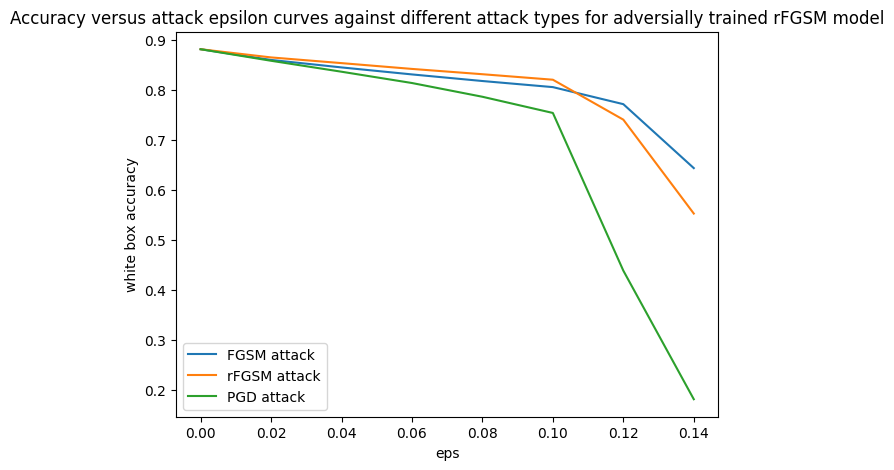

In [8]:
# plot the l_white_acc_fgsm
plt.figure(figsize=(7,5))
plt.plot(np.arange(0,0.14,0.02),l_white_acc_rfgsm[0],label="FGSM attack")
plt.plot(np.arange(0,0.14,0.02),l_white_acc_rfgsm[1],label="rFGSM attack")
plt.plot(np.arange(0,0.14,0.02),l_white_acc_rfgsm[2],label="PGD attack")
plt.xlabel("eps")
plt.ylabel("white box accuracy")
plt.title("Accuracy versus attack epsilon curves against different attack types for adversially trained rFGSM model")
plt.legend()
plt.show()

(d) 

PGD, ε = [0.0, 0.02, 0.04, . . . , 0.14]

In [9]:
l_white_acc_pgd = []
for i in ["FGSM", "rFGSM", "PGD"]:
    acc_eps=[]
    for j in np.arange(0,0.14,0.02):
        eps=j
        ite=10
        alp=1.85*(eps/ite)
        acc = whitebox_attack("netA_advtrain_pgd0p1.pt", i, eps, ite, alp)
        acc_eps.append(acc)
    l_white_acc_pgd.append(acc_eps)

Initial Accuracy of Whitebox Model:  0.866
Attack Epsilon: 0.0; Whitebox Accuracy: 0.866
Done!
Initial Accuracy of Whitebox Model:  0.866
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8504
Done!
Initial Accuracy of Whitebox Model:  0.866
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8393
Done!
Initial Accuracy of Whitebox Model:  0.866
Attack Epsilon: 0.06; Whitebox Accuracy: 0.828
Done!
Initial Accuracy of Whitebox Model:  0.866
Attack Epsilon: 0.08; Whitebox Accuracy: 0.8185
Done!
Initial Accuracy of Whitebox Model:  0.866
Attack Epsilon: 0.1; Whitebox Accuracy: 0.8103
Done!
Initial Accuracy of Whitebox Model:  0.866
Attack Epsilon: 0.12; Whitebox Accuracy: 0.7955
Done!
Initial Accuracy of Whitebox Model:  0.866
Attack Epsilon: 0.14; Whitebox Accuracy: 0.6938
Done!
Initial Accuracy of Whitebox Model:  0.866
Attack Epsilon: 0.0; Whitebox Accuracy: 0.866
Done!
Initial Accuracy of Whitebox Model:  0.866
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8536
Done!
Initial Accuracy of Whitebox Model: 

Attack Epsilon: 0.12; Whitebox Accuracy: 0.7859
Done!
Initial Accuracy of Whitebox Model:  0.866
Attack Epsilon: 0.14; Whitebox Accuracy: 0.6062
Done!
Initial Accuracy of Whitebox Model:  0.866
Attack Epsilon: 0.0; Whitebox Accuracy: 0.866
Done!
Initial Accuracy of Whitebox Model:  0.866
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8492
Done!
Initial Accuracy of Whitebox Model:  0.866
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8333
Done!
Initial Accuracy of Whitebox Model:  0.866
Attack Epsilon: 0.06; Whitebox Accuracy: 0.8179
Done!
Initial Accuracy of Whitebox Model:  0.866
Attack Epsilon: 0.08; Whitebox Accuracy: 0.8014
Done!
Initial Accuracy of Whitebox Model:  0.866
Attack Epsilon: 0.1; Whitebox Accuracy: 0.7827
Done!
Initial Accuracy of Whitebox Model:  0.866
Attack Epsilon: 0.12; Whitebox Accuracy: 0.6259
Done!
Initial Accuracy of Whitebox Model:  0.866
Attack Epsilon: 0.14; Whitebox Accuracy: 0.2904
Done!


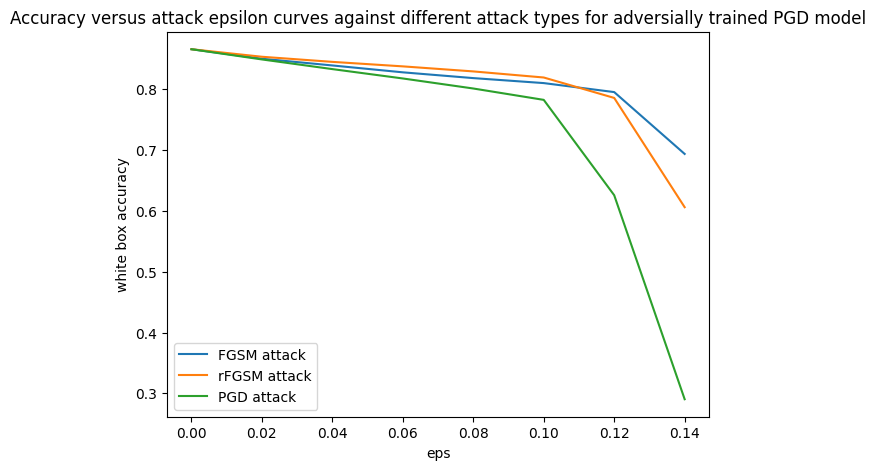

In [10]:
# plot the l_white_acc_fgsm
plt.figure(figsize=(7,5))
plt.plot(np.arange(0,0.14,0.02),l_white_acc_pgd[0],label="FGSM attack")
plt.plot(np.arange(0,0.14,0.02),l_white_acc_pgd[1],label="rFGSM attack")
plt.plot(np.arange(0,0.14,0.02),l_white_acc_pgd[2],label="PGD attack")
plt.xlabel("eps")
plt.ylabel("white box accuracy")
plt.title("Accuracy versus attack epsilon curves against different attack types for adversially trained PGD model")
plt.legend()
plt.show()

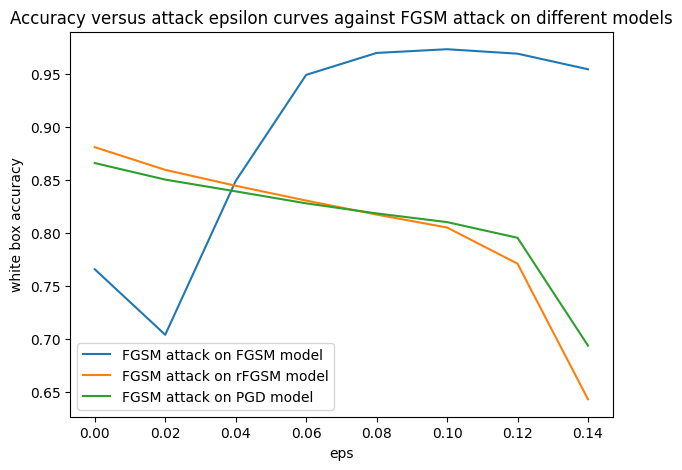

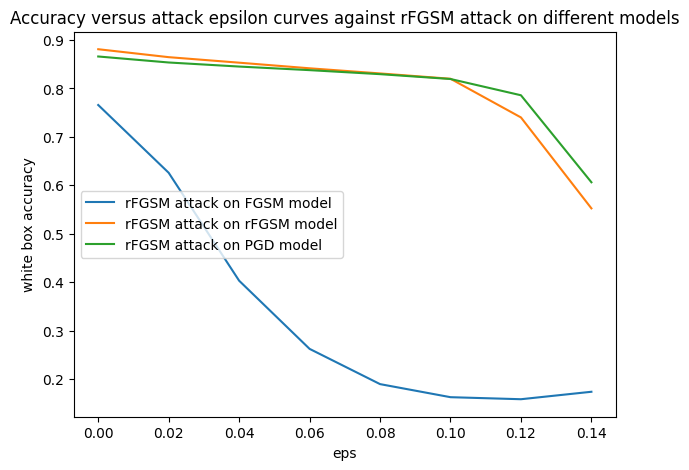

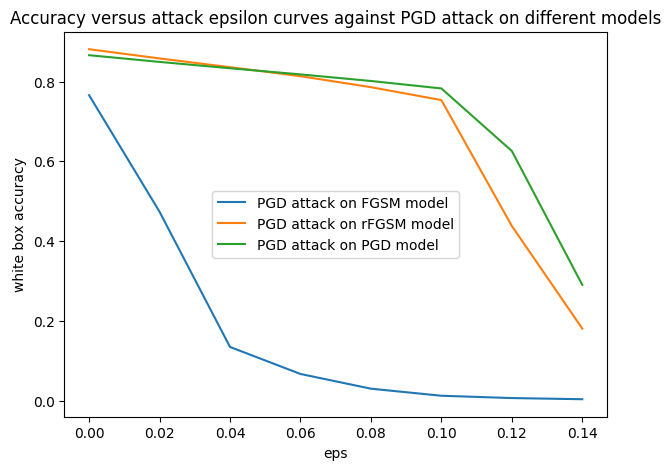

In [11]:
# plot the same attack type on different models
plt.figure(figsize=(7,5))
plt.plot(np.arange(0,0.14,0.02),l_white_acc_fgsm[0],label="FGSM attack on FGSM model")
plt.plot(np.arange(0,0.14,0.02),l_white_acc_rfgsm[0],label="FGSM attack on rFGSM model")
plt.plot(np.arange(0,0.14,0.02),l_white_acc_pgd[0],label="FGSM attack on PGD model")
plt.xlabel("eps")
plt.ylabel("white box accuracy")
plt.title("Accuracy versus attack epsilon curves against FGSM attack on different models")
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.plot(np.arange(0,0.14,0.02),l_white_acc_fgsm[1],label="rFGSM attack on FGSM model")
plt.plot(np.arange(0,0.14,0.02),l_white_acc_rfgsm[1],label="rFGSM attack on rFGSM model")
plt.plot(np.arange(0,0.14,0.02),l_white_acc_pgd[1],label="rFGSM attack on PGD model")
plt.xlabel("eps")
plt.ylabel("white box accuracy")
plt.title("Accuracy versus attack epsilon curves against rFGSM attack on different models")
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.plot(np.arange(0,0.14,0.02),l_white_acc_fgsm[2],label="PGD attack on FGSM model")
plt.plot(np.arange(0,0.14,0.02),l_white_acc_rfgsm[2],label="PGD attack on rFGSM model")
plt.plot(np.arange(0,0.14,0.02),l_white_acc_pgd[2],label="PGD attack on PGD model")
plt.xlabel("eps")
plt.ylabel("white box accuracy")
plt.title("Accuracy versus attack epsilon curves against PGD attack on different models")
plt.legend()
plt.show()


(e)

In [4]:
def train_pgd_model(name, eps):
    print("Training with epsilon:", eps)
    ## Pick a model architecture
    net = models.NetA().to(device)

    ## Checkpoint name for this model
    model_checkpoint = name

    ## Basic training params
    num_epochs = 20
    initial_lr = 0.001
    lr_decay_epoch = 15

    optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

    ## Training Loop
    l_test_acc_pgd0p1 = []
    l_test_loss_pgd0p1 = []

    for epoch in range(num_epochs):
        net.train()
        train_correct = 0.
        train_loss = 0.
        train_total = 0.
        for batch_idx,(data,labels) in enumerate(train_loader):
            data = data.to(device); labels = labels.to(device)

            # adversarial training
            # ε = 0.1, perturb_iters = 4, α = 1.85 ∗ (ε/perturb_iters)
            EPS = eps
            ITE = 4
            ALPHA = 1.85*(EPS/ITE)
            data = attacks.PGD_attack(model=net, dat=data, lbl=labels, eps=EPS, alpha=ALPHA, iters=ITE, device=device, rand_start=True)
            
            # Forward pass
            outputs = net(data)
            net.zero_grad()
            optimizer.zero_grad()
            # Compute loss, gradients, and update params
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            # Update stats
            _,preds = outputs.max(1)
            train_correct += preds.eq(labels).sum().item()
            train_loss += loss.item()
            train_total += labels.size(0)
            
        # End of training epoch
        test_acc,test_loss = test_model(net,test_loader,device)
        print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
            epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
            test_acc, test_loss,
        ))
        l_test_acc_pgd0p1.append(test_acc)
        l_test_loss_pgd0p1.append(test_loss)
        
        # Save model    
        torch.save(net.state_dict(), model_checkpoint)
        
        # Update LR
        if epoch == lr_decay_epoch:
            for param_group in optimizer.param_groups:
                param_group['lr'] = initial_lr*0.1

    print("Done!\n")

In [8]:
train_pgd_model("netA_advtrain_pgd0p05.pt", 0.05)
train_pgd_model("netA_advtrain_pgd0p2.pt", 0.2)
train_pgd_model("netA_advtrain_pgd0p3.pt", 0.3)
# train_pgd_model("netA_advtrain_pgd0p4.pt", 0.4)

Training with epsilon: 0.05
Epoch: [ 0 / 20 ]; TrainAcc: 0.72623; TrainLoss: 0.68988; TestAcc: 0.84500; TestLoss: 0.41041
Epoch: [ 1 / 20 ]; TrainAcc: 0.78707; TrainLoss: 0.53452; TestAcc: 0.86060; TestLoss: 0.35878
Epoch: [ 2 / 20 ]; TrainAcc: 0.80205; TrainLoss: 0.49605; TestAcc: 0.86630; TestLoss: 0.35708
Epoch: [ 3 / 20 ]; TrainAcc: 0.81060; TrainLoss: 0.47196; TestAcc: 0.87030; TestLoss: 0.33785
Epoch: [ 4 / 20 ]; TrainAcc: 0.81617; TrainLoss: 0.45595; TestAcc: 0.87430; TestLoss: 0.33320
Epoch: [ 5 / 20 ]; TrainAcc: 0.82028; TrainLoss: 0.44434; TestAcc: 0.87810; TestLoss: 0.32088
Epoch: [ 6 / 20 ]; TrainAcc: 0.82575; TrainLoss: 0.43178; TestAcc: 0.87890; TestLoss: 0.31958
Epoch: [ 7 / 20 ]; TrainAcc: 0.82838; TrainLoss: 0.42182; TestAcc: 0.87390; TestLoss: 0.32484
Epoch: [ 8 / 20 ]; TrainAcc: 0.83187; TrainLoss: 0.41276; TestAcc: 0.88150; TestLoss: 0.31499
Epoch: [ 9 / 20 ]; TrainAcc: 0.83495; TrainLoss: 0.40366; TestAcc: 0.87830; TestLoss: 0.31725
Epoch: [ 10 / 20 ]; TrainAcc: 0.

In [9]:
def attack_pgd_trained_model(model, eps_range):
    print("Testing with model:", model)
    l_white_acc_pgd = []
    for i in ["FGSM", "rFGSM", "PGD"]:
        acc_eps=[]
        for j in eps_range:
            eps=j
            ite=10
            alp=1.85*(eps/ite)
            acc = whitebox_attack(model, i, eps, ite, alp)
            acc_eps.append(acc)
        l_white_acc_pgd.append(acc_eps)
    return l_white_acc_pgd

In [16]:
l_test_loss_pgd0p05 = attack_pgd_trained_model("netA_advtrain_pgd0p05.pt", np.arange(0,0.4,0.04))
l_white_acc_pgd0p1 = attack_pgd_trained_model("netA_advtrain_pgd0p1.pt", np.arange(0,0.4,0.04))
l_white_acc_pgd0p2 = attack_pgd_trained_model("netA_advtrain_pgd0p2.pt", np.arange(0,0.4,0.04))
l_white_acc_pgd0p3 = attack_pgd_trained_model("netA_advtrain_pgd0p3.pt", np.arange(0,0.4,0.04))
# l_white_acc_pgd0p4 = attack_pgd_trained_model("netA_advtrain_pgd0p4.pt", np.arange(0,0.4,0.04))

Testing with model: netA_advtrain_pgd0p05.pt
Initial Accuracy of Whitebox Model:  0.8941
Attack Epsilon: 0.0; Whitebox Accuracy: 0.8941
Done!
Initial Accuracy of Whitebox Model:  0.8941
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8473
Done!
Initial Accuracy of Whitebox Model:  0.8941
Attack Epsilon: 0.08; Whitebox Accuracy: 0.8006
Done!
Initial Accuracy of Whitebox Model:  0.8941
Attack Epsilon: 0.12; Whitebox Accuracy: 0.7336
Done!
Initial Accuracy of Whitebox Model:  0.8941
Attack Epsilon: 0.16; Whitebox Accuracy: 0.57
Done!
Initial Accuracy of Whitebox Model:  0.8941
Attack Epsilon: 0.2; Whitebox Accuracy: 0.3639
Done!
Initial Accuracy of Whitebox Model:  0.8941
Attack Epsilon: 0.24; Whitebox Accuracy: 0.2556
Done!
Initial Accuracy of Whitebox Model:  0.8941
Attack Epsilon: 0.28; Whitebox Accuracy: 0.1973
Done!
Initial Accuracy of Whitebox Model:  0.8941
Attack Epsilon: 0.32; Whitebox Accuracy: 0.1607
Done!
Initial Accuracy of Whitebox Model:  0.8941
Attack Epsilon: 0.36; Whitebox Ac

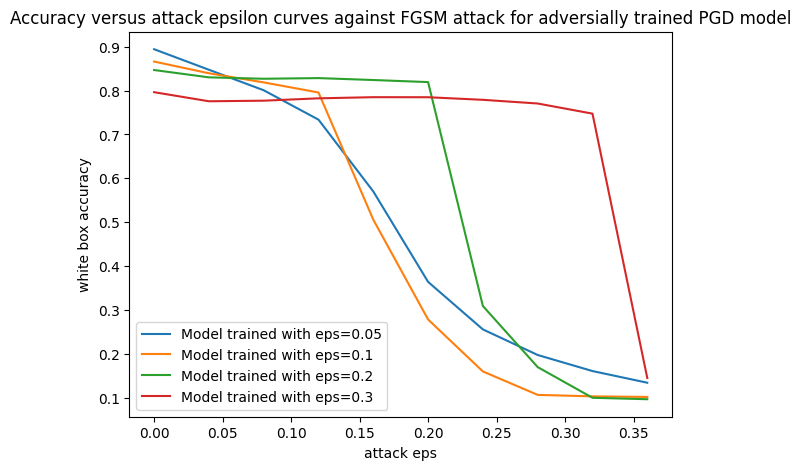

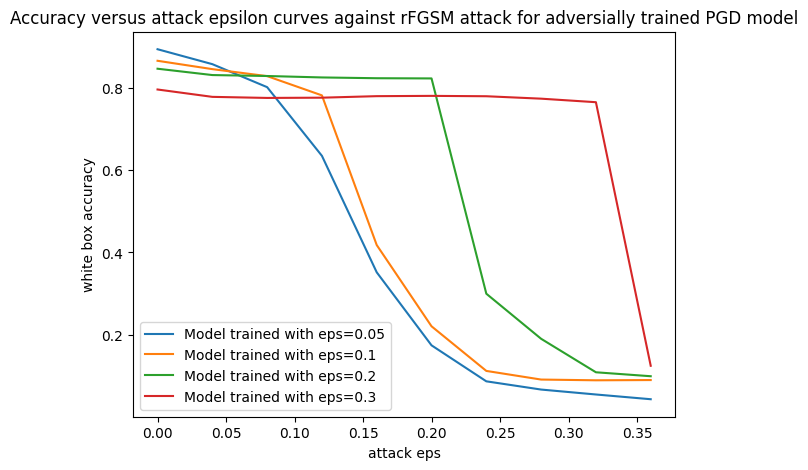

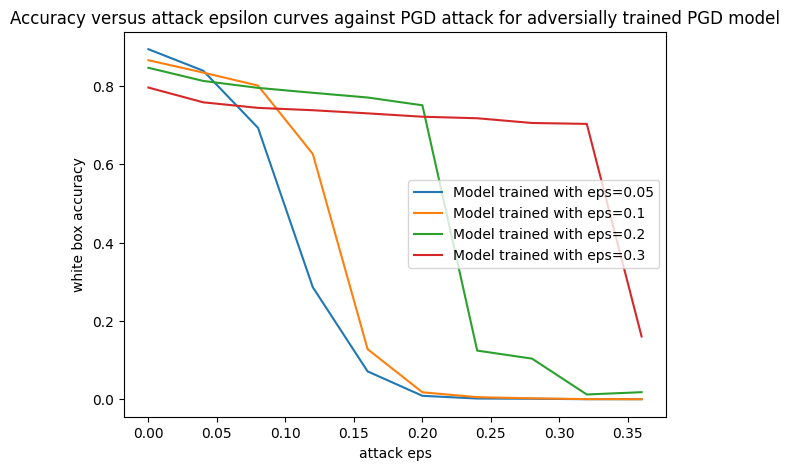

In [17]:
# plot FGSM attack on 4 models in one plot, rFGSM attack on 4 models in one plot, PGD attack on 4 models in one plot
plt.figure(figsize=(7,5))
plt.plot(np.arange(0,0.4,0.04),l_test_loss_pgd0p05[0],label="Model trained with eps=0.05")
plt.plot(np.arange(0,0.4,0.04),l_white_acc_pgd0p1[0],label="Model trained with eps=0.1")
plt.plot(np.arange(0,0.4,0.04),l_white_acc_pgd0p2[0],label="Model trained with eps=0.2")
plt.plot(np.arange(0,0.4,0.04),l_white_acc_pgd0p3[0],label="Model trained with eps=0.3")
# plt.plot(np.arange(0,0.4,0.04),l_white_acc_pgd0p4[0],label="Model trained with eps=0.4")
plt.xlabel("attack eps")
plt.ylabel("white box accuracy")
plt.title("Accuracy versus attack epsilon curves against FGSM attack for adversially trained PGD model")
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.plot(np.arange(0,0.4,0.04),l_test_loss_pgd0p05[1],label="Model trained with eps=0.05")
plt.plot(np.arange(0,0.4,0.04),l_white_acc_pgd0p1[1],label="Model trained with eps=0.1")
plt.plot(np.arange(0,0.4,0.04),l_white_acc_pgd0p2[1],label="Model trained with eps=0.2")
plt.plot(np.arange(0,0.4,0.04),l_white_acc_pgd0p3[1],label="Model trained with eps=0.3")
# plt.plot(np.arange(0,0.4,0.04),l_white_acc_pgd0p4[1],label="Model trained with eps=0.4")
plt.xlabel("attack eps")
plt.ylabel("white box accuracy")
plt.title("Accuracy versus attack epsilon curves against rFGSM attack for adversially trained PGD model")
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.plot(np.arange(0,0.4,0.04),l_test_loss_pgd0p05[2],label="Model trained with eps=0.05")
plt.plot(np.arange(0,0.4,0.04),l_white_acc_pgd0p1[2],label="Model trained with eps=0.1")
plt.plot(np.arange(0,0.4,0.04),l_white_acc_pgd0p2[2],label="Model trained with eps=0.2")
plt.plot(np.arange(0,0.4,0.04),l_white_acc_pgd0p3[2],label="Model trained with eps=0.3")
# plt.plot(np.arange(0,0.4,0.04),l_white_acc_pgd0p4[2],label="Model trained with eps=0.4")
plt.xlabel("attack eps")
plt.ylabel("white box accuracy")
plt.title("Accuracy versus attack epsilon curves against PGD attack for adversially trained PGD model")
plt.legend()
plt.show()

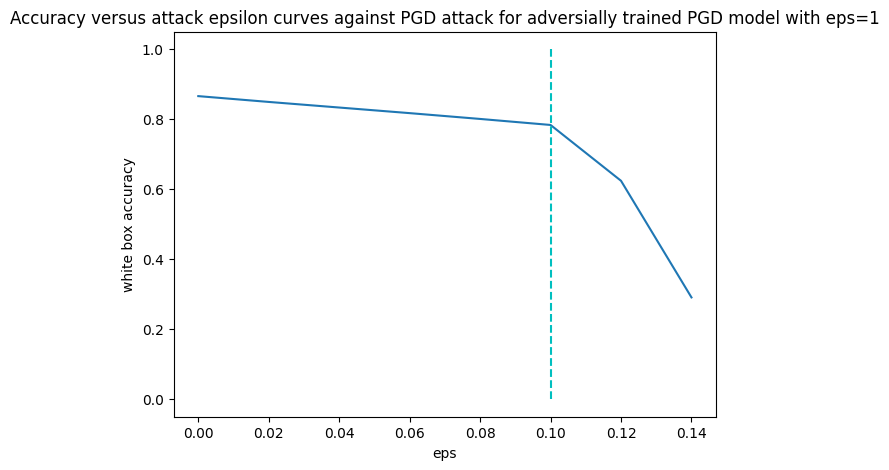

In [55]:
plt.figure(figsize=(7,5))
plt.plot(np.arange(0,0.14,0.02),l_white_acc_pgd0p1[2])
plt.xlabel("eps")
plt.ylabel("white box accuracy")
plt.vlines(0.1, 0, 1, colors = "c", linestyles = "dashed", label="eps=0.1")
plt.title("Accuracy versus attack epsilon curves against PGD attack for adversially trained PGD model with eps=1")
plt.show()

(f)

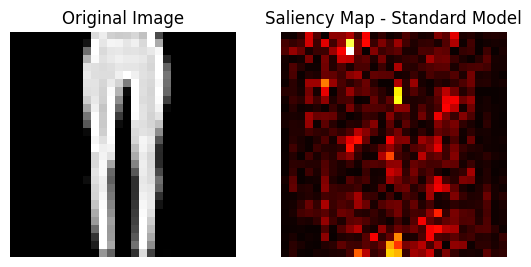

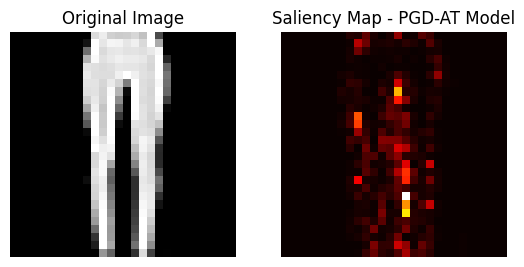

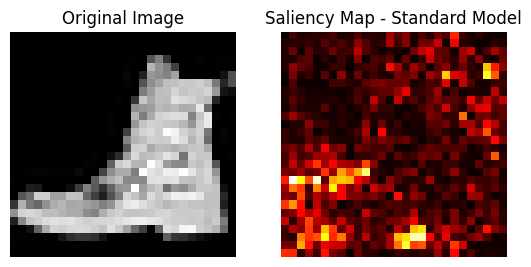

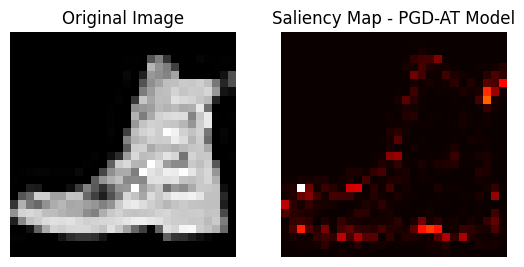

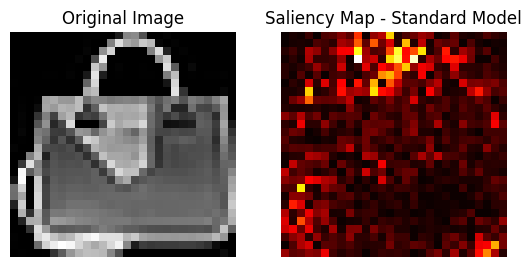

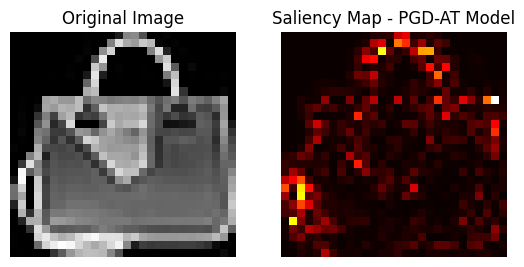

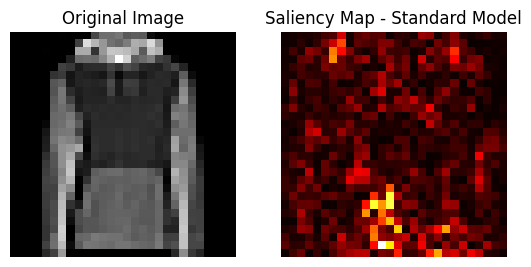

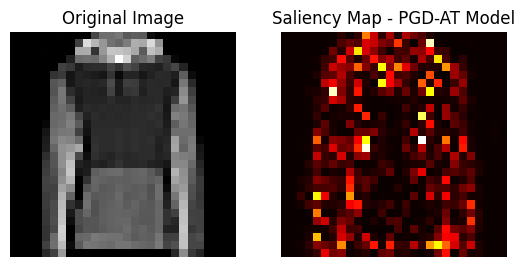

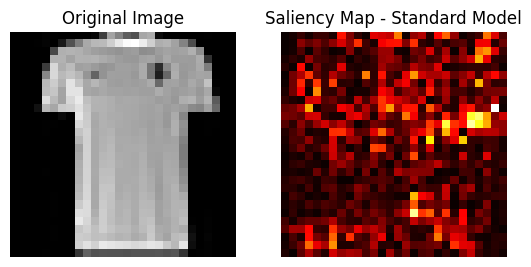

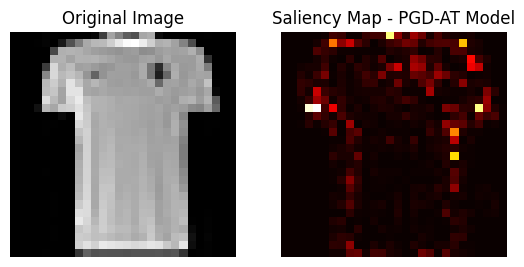

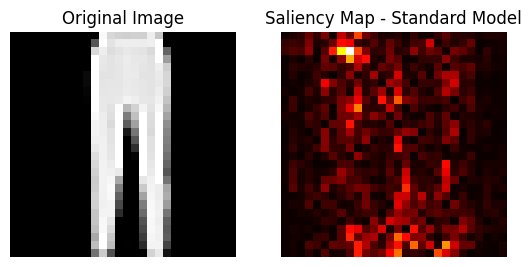

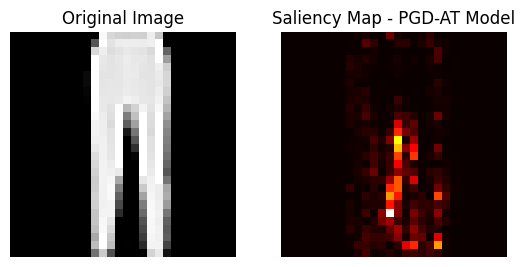

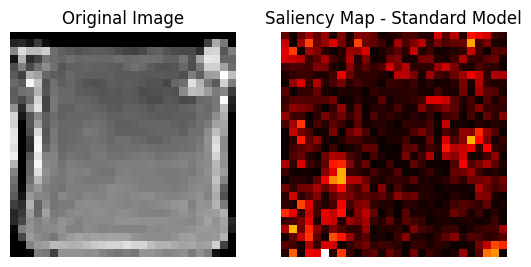

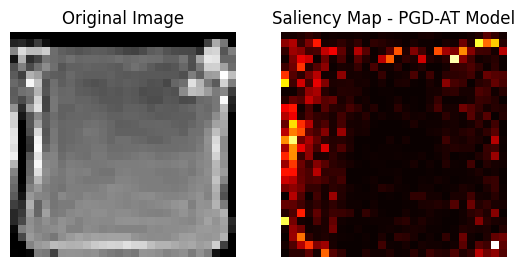

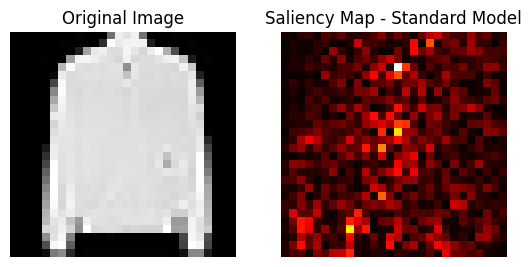

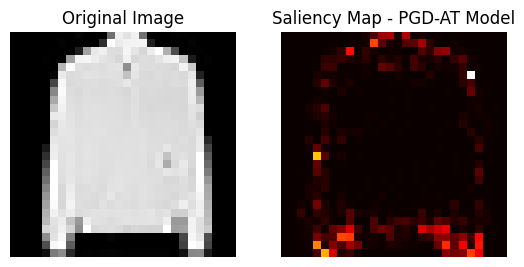

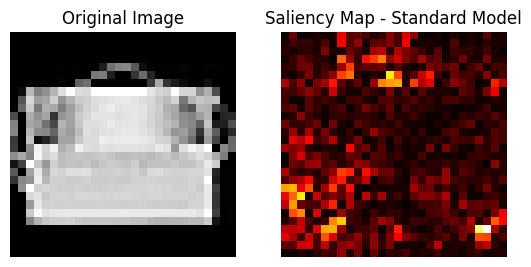

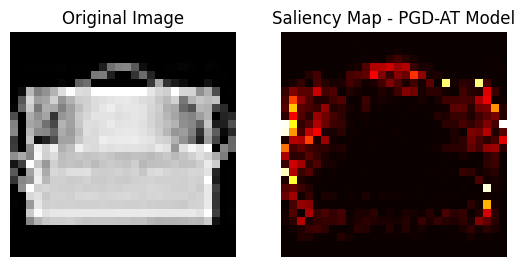

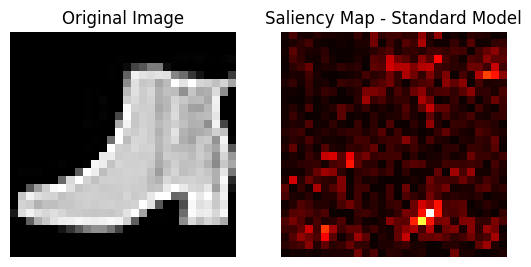

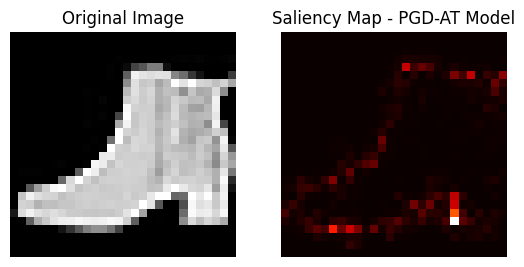

In [36]:
# load model
model_standard = models.NetA()
model_standard.load_state_dict(torch.load('netA_standard.pt'))
model_standard.eval()

model_pgd_at = models.NetA()
model_pgd_at.load_state_dict(torch.load('netA_advtrain_pgd0p05.pt'))
model_pgd_at.eval()

def plot_saliency_maps(model, data, target, title):
    model.to(device)
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    
    # Forward pass
    output = model(data)
    loss = F.nll_loss(output, target)
    
    # Backward pass
    model.zero_grad()
    loss.backward()
    
    # Saliency map is the gradient of the output wrt. input image
    saliency = data.grad.data.abs().squeeze()
    
    # Plot original image and saliency map
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(data.squeeze().detach().cpu().numpy(), cmap='gray')  
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    ax[1].imshow(saliency.cpu(), cmap=plt.cm.hot)
    ax[1].set_title(f'Saliency Map - {title}')
    ax[1].axis('off')
    plt.show()

# Get a few sample data from the test set
sample_count = 0
for data, target in test_loader:
    plot_saliency_maps(model_standard, data, target, title='Standard Model')
    plot_saliency_maps(model_pgd_at, data, target, title='PGD-AT Model')
    sample_count += 1
    
    # Break after a few samples
    if sample_count == 10:
        break
